# **1. AI Forecasting: SETUP**

In [1]:
#CELL-1

!pip install kaleido==0.2.1
!pip install -U numpy statsmodels
!pip install pmdarima

In [2]:
#CELL-2

# Standard Libraries
import warnings
import itertools
import time

# Data Handling
import pandas as pd
import numpy as np

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Time Series - Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Automated Time Series - Pmdarima
#import pmdarima as pm

# Deep Learning - TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import pandas as pd
import numpy as np
import warnings
import time
import itertools
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


# **2. Data Loading & Cleaning**

In [7]:
#CELL-3

# Step-1 > Define the file path
file_path = 'covid_19_clean_complete.csv'

# --- Load the CSV file into a pandas DataFrame ---
try:
    print(f"Attempting to load file: '{file_path}'")
    df = pd.read_csv(file_path)

    # --- Display the first few rows of the data ---
    print("\nSuccessfully loaded the data. Here are the first 5 rows:")
    print(df.head())

except FileNotFoundError:
    print(f"\nError: The file '{file_path}' was not found.")
    print("Please make sure you have uploaded the file to the Colab session using the file browser on the left.")

except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Attempting to load file: 'covid_19_clean_complete.csv'

Successfully loaded the data. Here are the first 5 rows:
  Province/State Country/Region       Lat       Long        Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953  2020-01-22          0   
1            NaN        Albania  41.15330  20.168300  2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600  2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800  2020-01-22          0   
4            NaN         Angola -11.20270  17.873900  2020-01-22          0   

   Deaths  Recovered  Active             WHO Region  
0       0          0       0  Eastern Mediterranean  
1       0          0       0                 Europe  
2       0          0       0                 Africa  
3       0          0       0                 Europe  
4       0          0       0                 Africa  


In [8]:
#CELL-4

# Step-2 > Basic Exploratory Data Analysis

print("--- Basic Information ---")

# dimensions of the DataFrame (rows, columns)
print("\n1. Data Shape:")
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# concise summary of the DataFrame.
print("\n2. Data Info:")
df.info()

# missing values in each column
print("\n3. Missing Values Count:")
print("Count of nulls in each column:")
print(df.isnull().sum())

# descriptive statistics for numerical columns.
print("\n4. Descriptive Statistics (Numerical Columns):")
print(df.describe())

# descriptive statistics for categorical/object columns.
print("\n5. Descriptive Statistics (Categorical Columns):")
print(df.describe(include=['object']))


--- Basic Information ---

1. Data Shape:
The dataset has 49068 rows and 10 columns.

2. Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB

3. Missing Values Count:
Count of nulls in each column:
Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed   

# **3. EDA: Exploratory Data Analysis and Visualisations**

In [13]:
#CELL-5

# Step-3 > Data Cleaning

# Step-3.1 > Convert Date format to 'DDMMYYYY'

df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d%m%Y')

print("\nStep 3.1 > Date format has been updated. Here are the first 3 rows:")
print(df.head(3))




# Step-3.2 > Check for Inconsistencies

# Calculate what the 'Active' column *should* be
df['Calculated_Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']

# --- FIX: Add this line to update the 'Active' column ---
df['Active'] = df['Calculated_Active']
# ---------------------------------------------------------

# Now, you can find inconsistent rows (there should be 0 now) and report on them
inconsistent_rows = df[df['Active'] != df['Calculated_Active']]
print(f"\nStep 3.2 > Found {len(inconsistent_rows)} rows with inconsistent 'Active' case counts after correction.")

# Clean up by removing the temporary column
df.drop(columns=['Calculated_Active'], inplace=True)




# Step 3.3 > Create a Unified Location Column [Country-Province / Country]

# Filling missing 'Province/State' values with an *empty string*, making easier to combine columns without errors.
df['Province/State'] = df['Province/State'].fillna('')

# Creating the new 'Location' column
df['Location'] = np.where(
    df['Province/State'] != '',
    df['Country/Region'] + ' - ' + df['Province/State'],
    df['Country/Region']
)

print("\nStep 3.3 > some examples:")

# Displaying a sample including countries with and without provinces
print(df[df['Country/Region'].isin(['Australia', 'India', 'France'])][['Country/Region', 'Province/State', 'Location']].head(3))

# We can now drop the original 'Province/State' and 'Country/Region' if we want, but it's good practice to keep them for now.




# Step 3.4 > Checking for Duplicates

# Find all rows that are complete duplicates of another row
duplicate_rows = df[df.duplicated()]

# Count how many duplicate rows were found
num_duplicates = len(duplicate_rows)

# Report the result
if num_duplicates > 0:
    print(f"Found {num_duplicates} duplicate rows in the dataset.")
    print("\nStep 3.4 > Here are the duplicate rows:")
    print(duplicate_rows)
else:
    print("\nStep 3.4 > No duplicate rows were found in the dataset.")




# Step-3.5 > Sorting columns for Time series analysis

df['Date'] = pd.to_datetime(df['Date'], format='%d%m%Y')

# Sort the DataFrame by Location, then by Date ---
df_sorted = df.sort_values(by=['Location', 'Date'])
print("\nStep 3.5 > Data has been sorted by Location and Date. Here's a preview:")
df_sorted.head(3)


Step 3.1 > Date format has been updated. Here are the first 3 rows:
  Province/State Country/Region       Lat       Long      Date  Confirmed  \
0                   Afghanistan  33.93911  67.709953  22012020          0   
1                       Albania  41.15330  20.168300  22012020          0   
2                       Algeria  28.03390   1.659600  22012020          0   

   Deaths  Recovered  Active             WHO Region     Location  
0       0          0       0  Eastern Mediterranean  Afghanistan  
1       0          0       0                 Europe      Albania  
2       0          0       0                 Africa      Algeria  

Step 3.2 > Found 0 rows with inconsistent 'Active' case counts after correction.

Step 3.3 > some examples:
   Country/Region                Province/State  \
8       Australia  Australian Capital Territory   
9       Australia               New South Wales   
10      Australia            Northern Territory   

                                    Loca

Province/State Country/Region       Lat       Long       Date  Confirmed  \
0                     Afghanistan  33.93911  67.709953 2020-01-22          0   
261                   Afghanistan  33.93911  67.709953 2020-01-23          0   
522                   Afghanistan  33.93911  67.709953 2020-01-24          0   

     Deaths  Recovered  Active             WHO Region     Location  
0         0          0       0  Eastern Mediterranean  Afghanistan  
261       0          0       0  Eastern Mediterranean  Afghanistan  
522       0          0       0  Eastern Mediterranean  Afghanistan

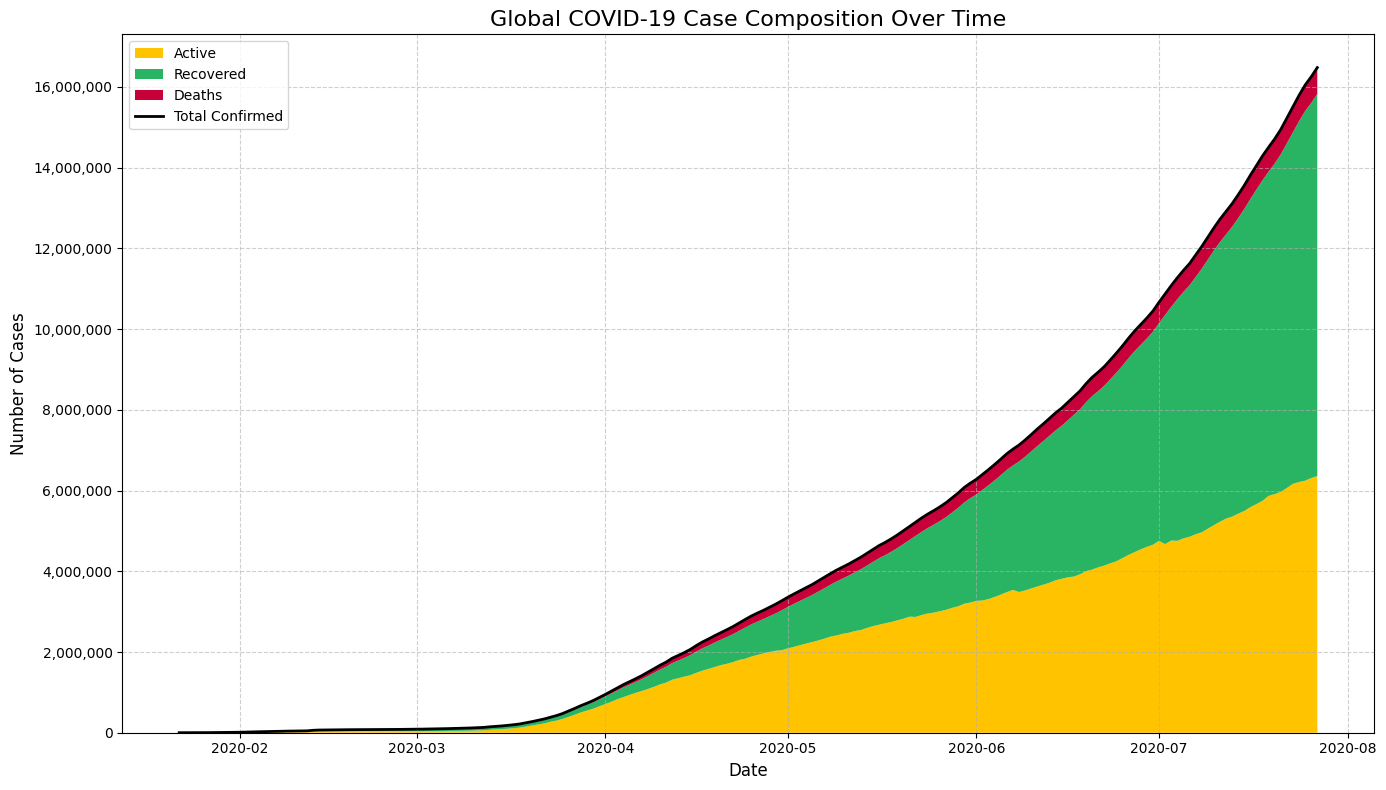

In [14]:
#Cell-6

# Step-4.1 > Present Trend of the Active Cases
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

# --- 1. Data Aggregation ---
# Group the global data by date and sum the cases
df_global = df.groupby('Date').sum()

# Define the columns for the stacked plot
stack_cols = ['Active', 'Recovered', 'Deaths']
# Define the colors for the stacks
stack_colors = ['#FFC300', '#28B463', '#C70039'] # Yellow, Green, Red

# --- 2. Create the Plot ---
plt.figure(figsize=(14, 8))

# Create the stacked area plot
plt.stackplot(df_global.index,
              df_global[stack_cols].T, # Transpose is needed for stackplot
              labels=stack_cols,
              colors=stack_colors)

# Overlay the 'Confirmed' cases as a line plot
plt.plot(df_global.index, df_global['Confirmed'], color='black', linewidth=2, label='Total Confirmed')


# --- 3. Formatting ---
# Format the Y-axis to show full numbers with commas
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add titles and labels
plt.title('Global COVID-19 Case Composition Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


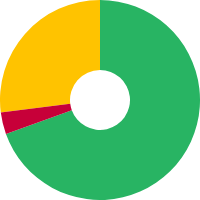
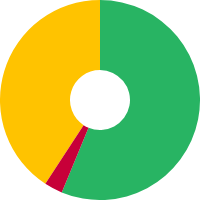
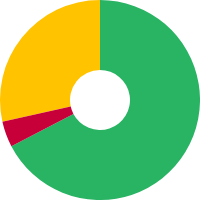
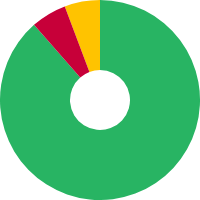
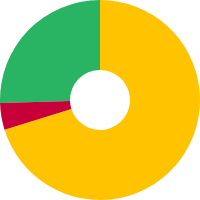
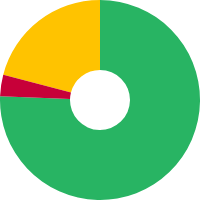
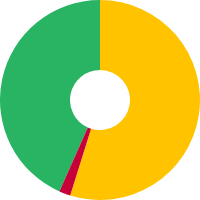
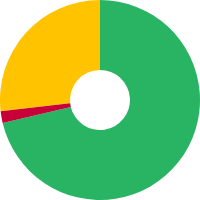
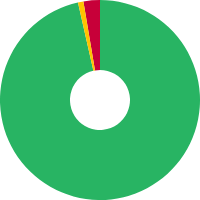
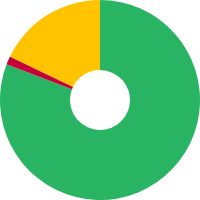
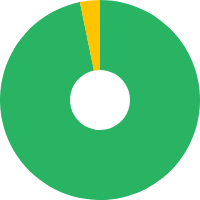
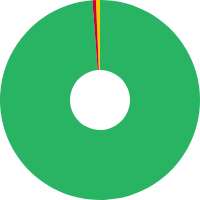
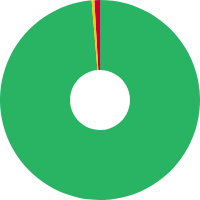
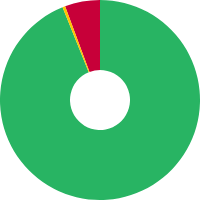
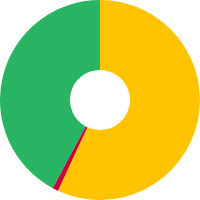
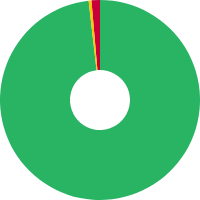
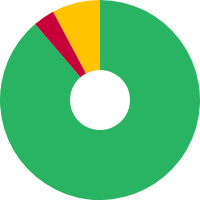
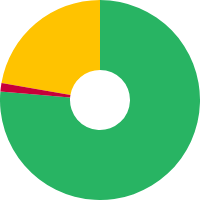
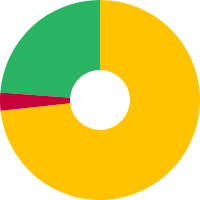
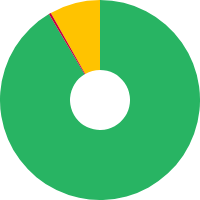
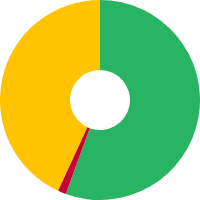
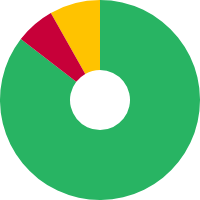
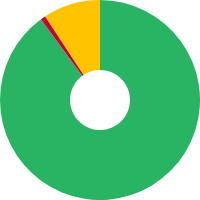
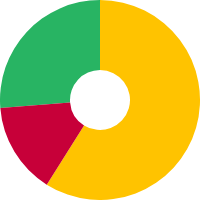
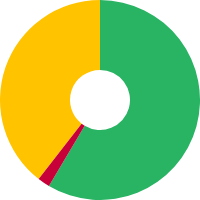
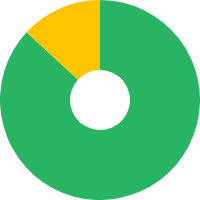
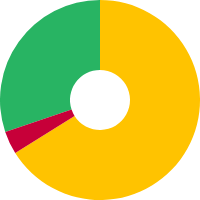
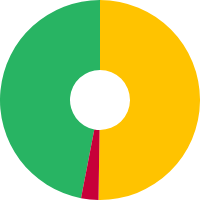
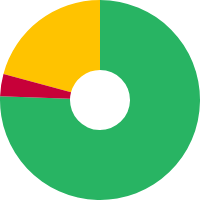
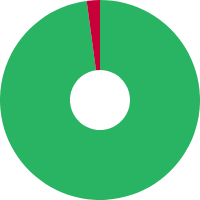
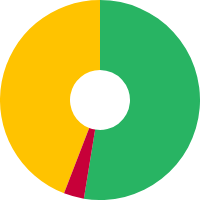
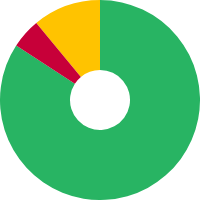
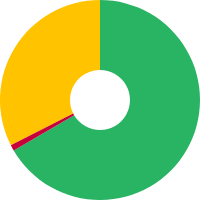
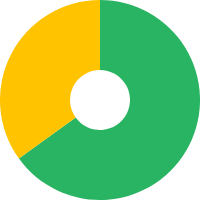
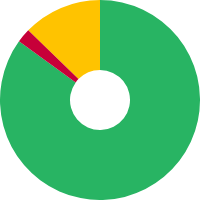
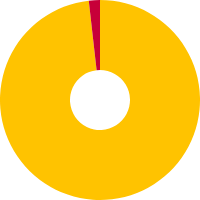
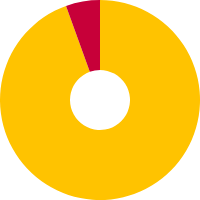
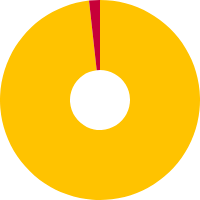
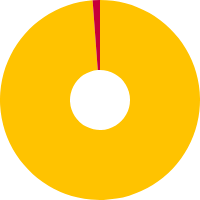
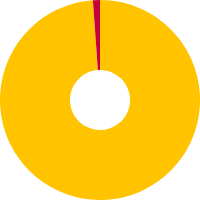
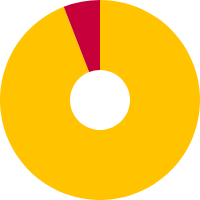
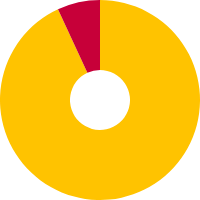
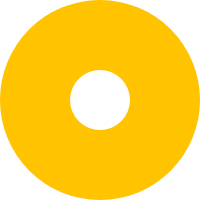
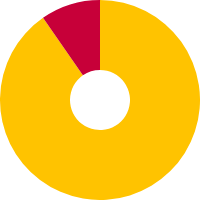
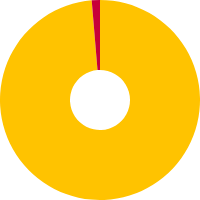
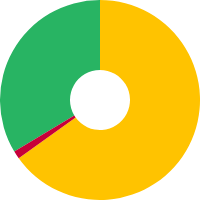
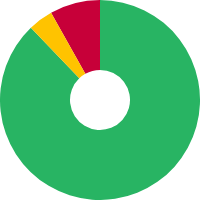
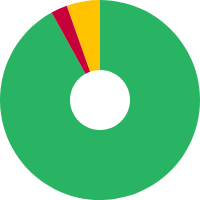
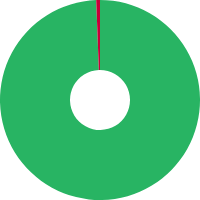
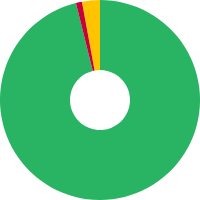
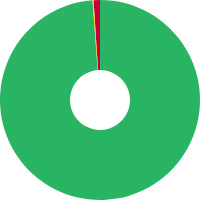
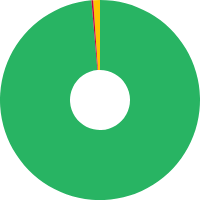
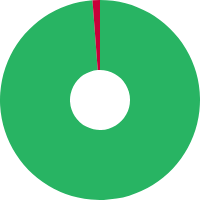
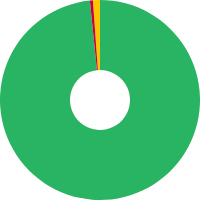
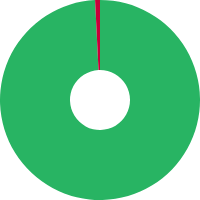
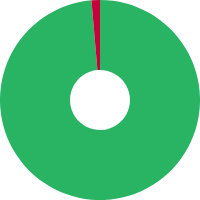
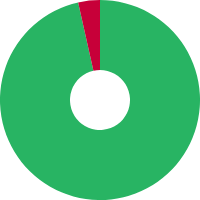
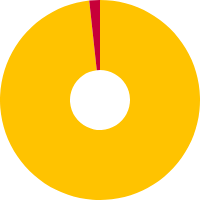
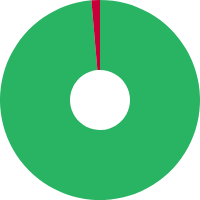
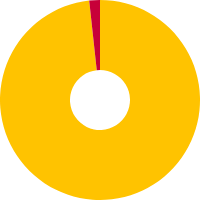
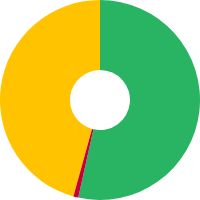
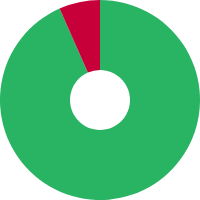
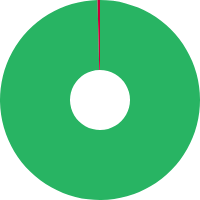
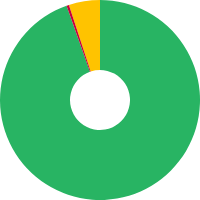
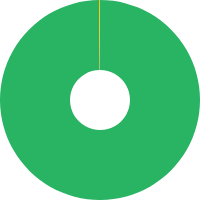
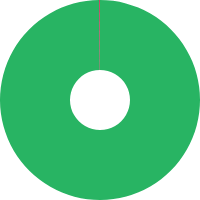
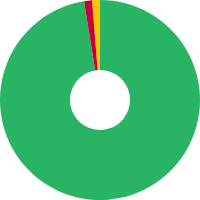
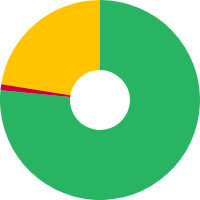
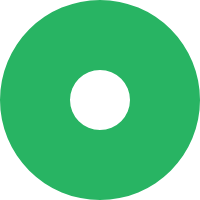
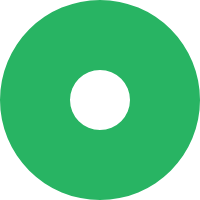
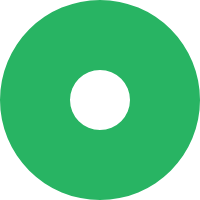
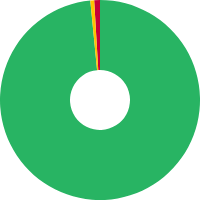
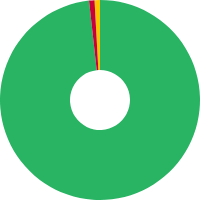
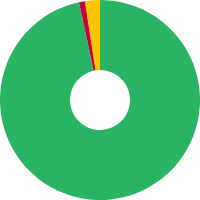
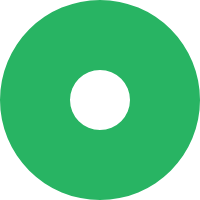
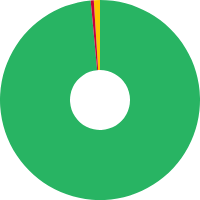
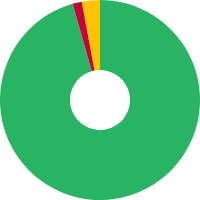
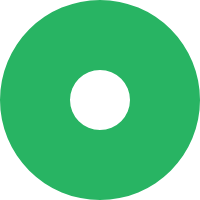
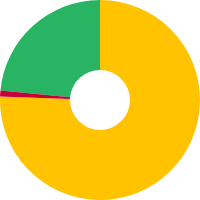
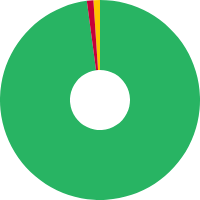
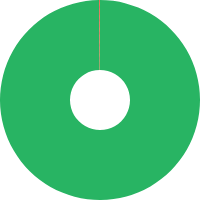
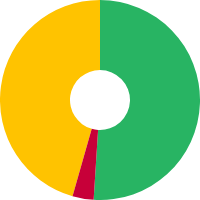
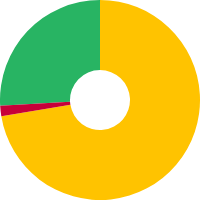
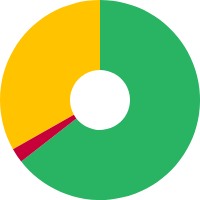
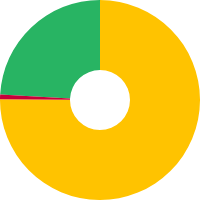
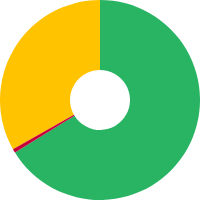
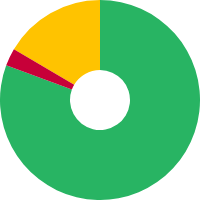
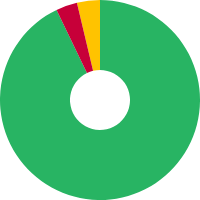
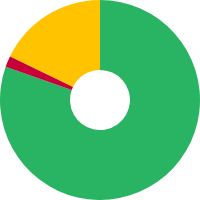
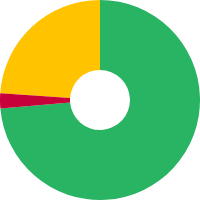
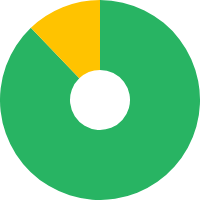
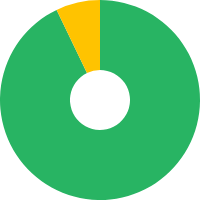
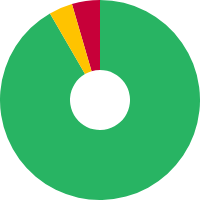
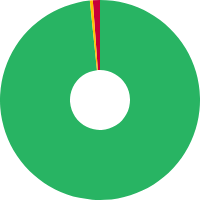
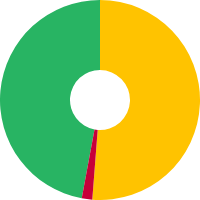
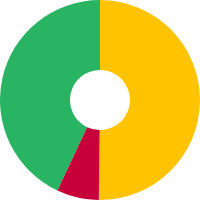
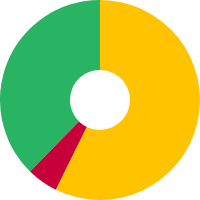
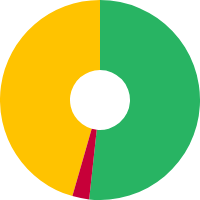
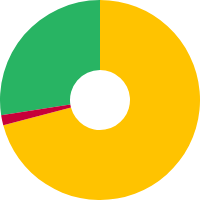
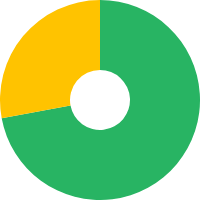
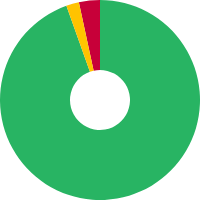
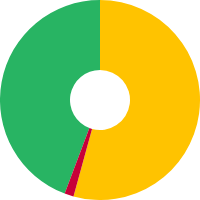
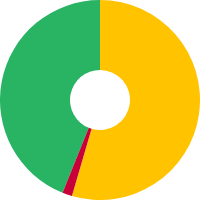
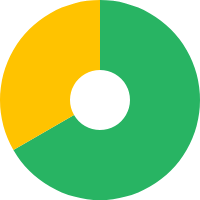
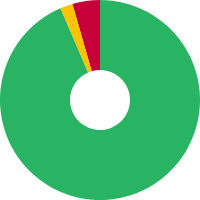
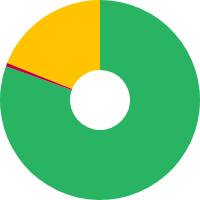
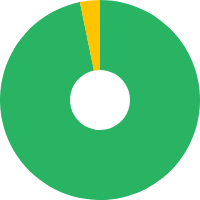
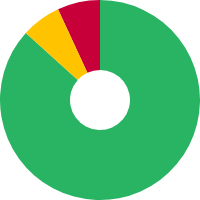
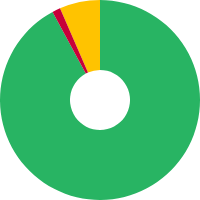
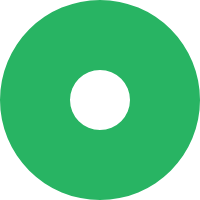
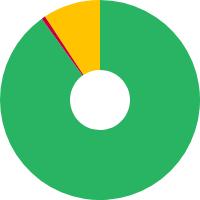
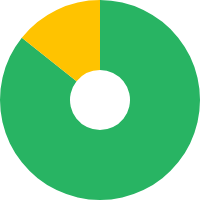
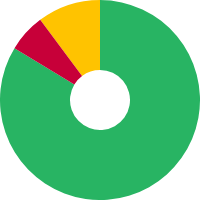
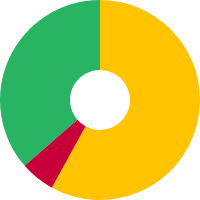
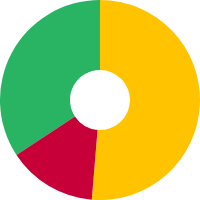
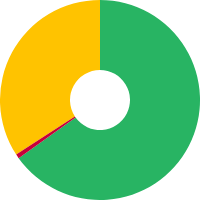
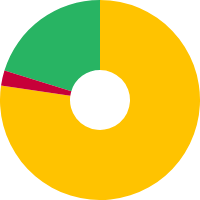
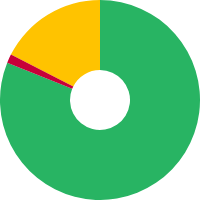
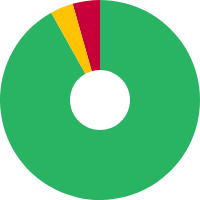
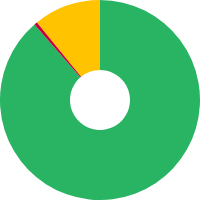
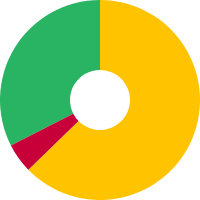
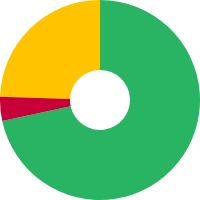
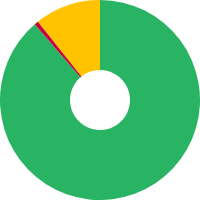
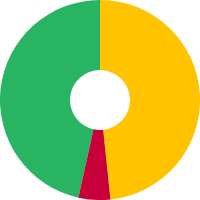
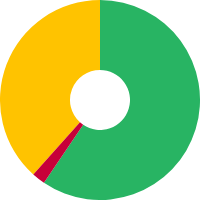
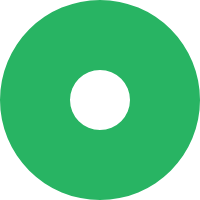
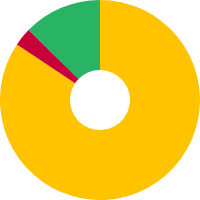
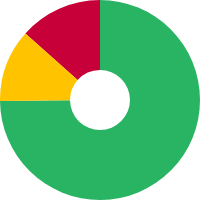
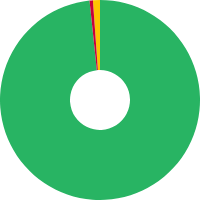
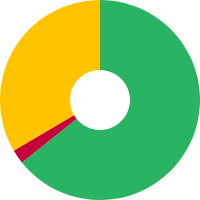
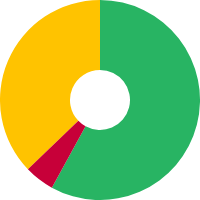
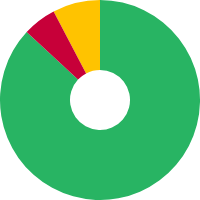
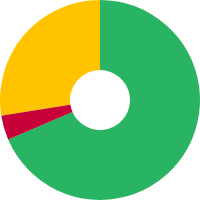
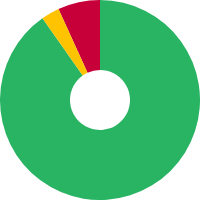
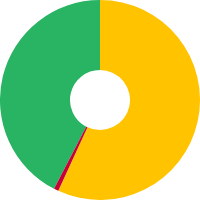
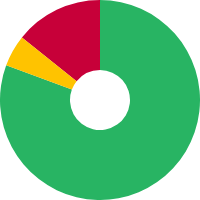
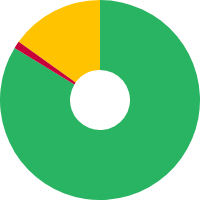
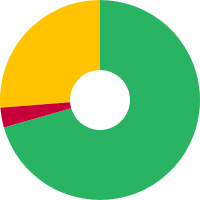
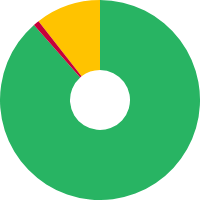
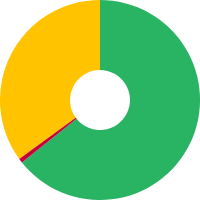
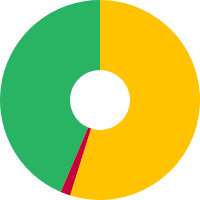
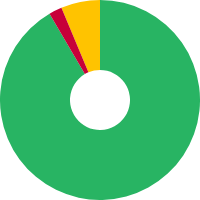
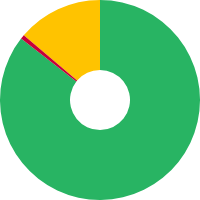
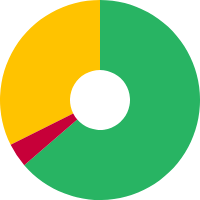
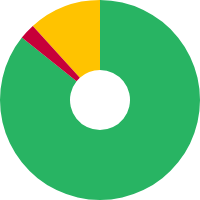
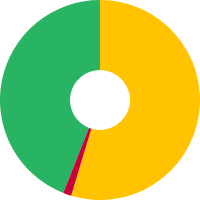
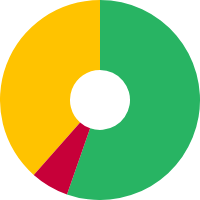
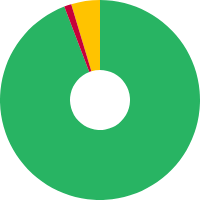
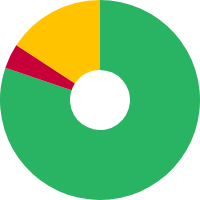
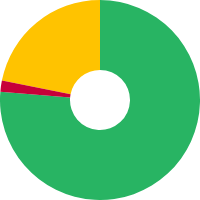
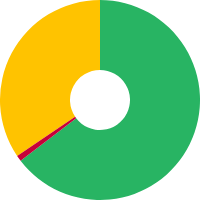
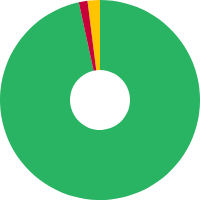
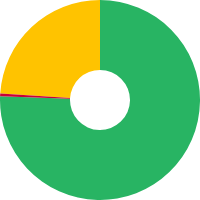
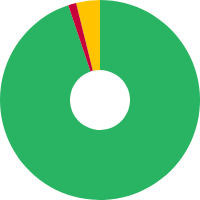
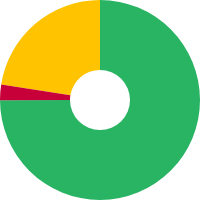
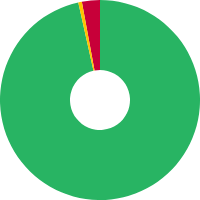
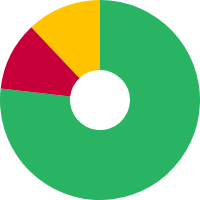
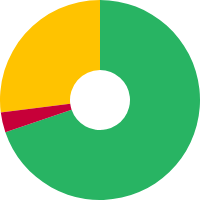
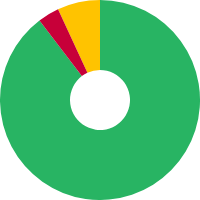
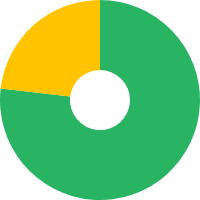
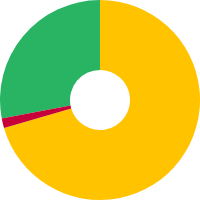
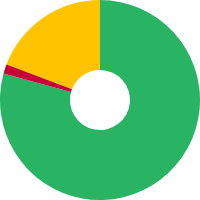
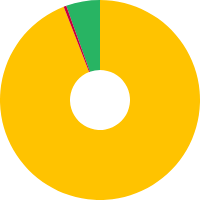
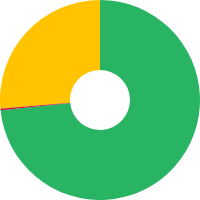
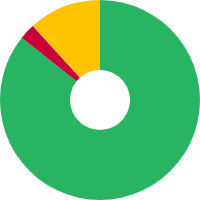
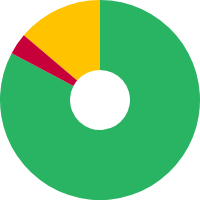
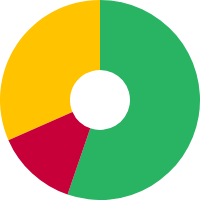
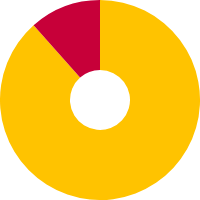
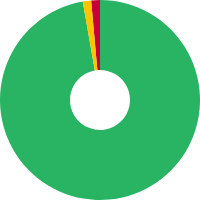
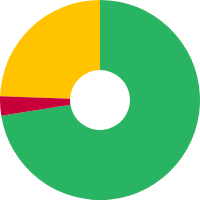
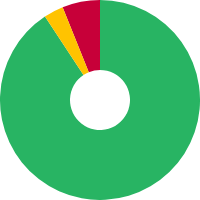
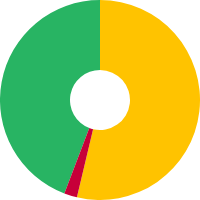
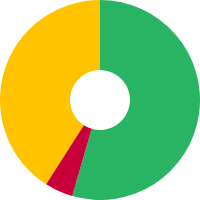
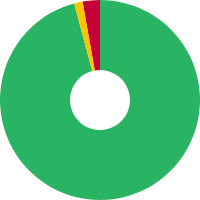
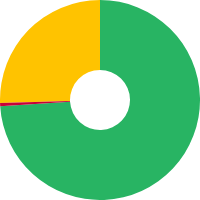
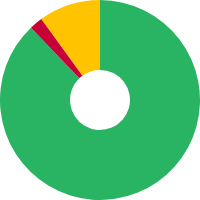
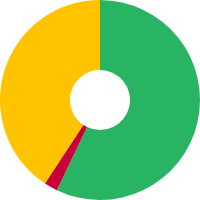
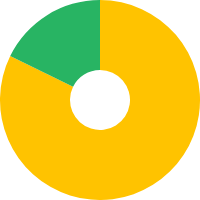
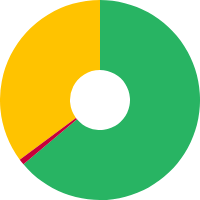
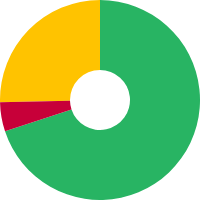
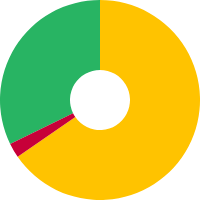
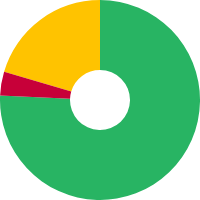
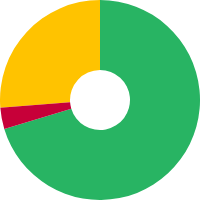
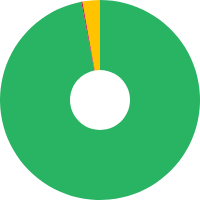
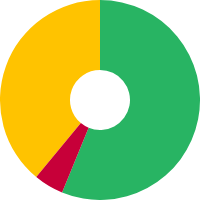
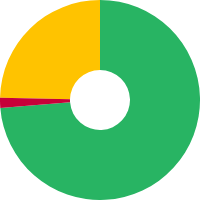
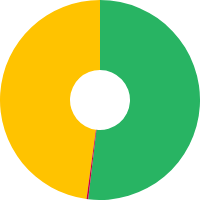
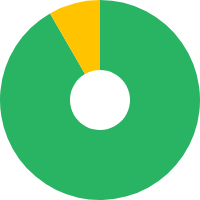
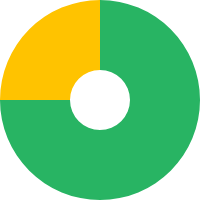
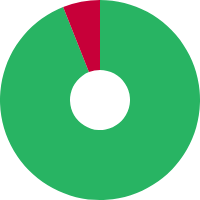
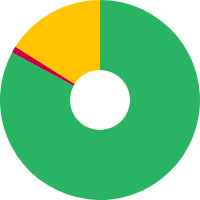
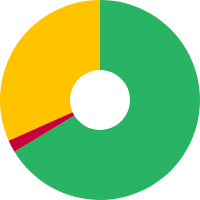
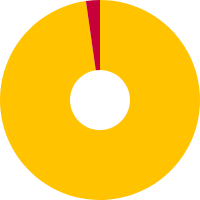
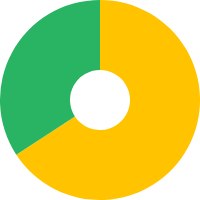
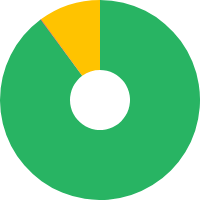
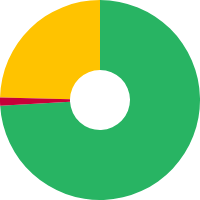
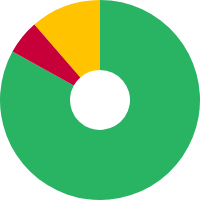
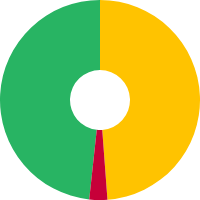
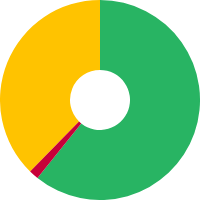
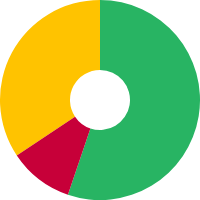
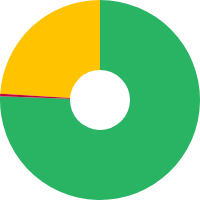
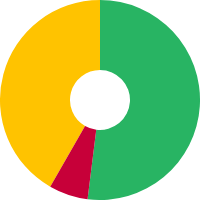
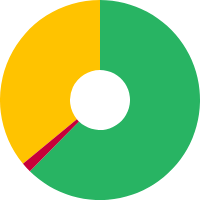
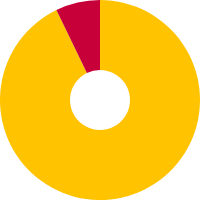
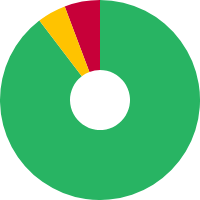
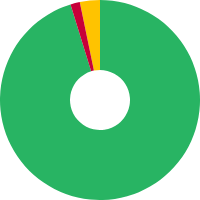
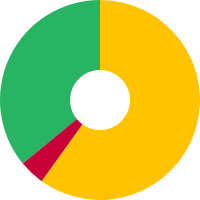
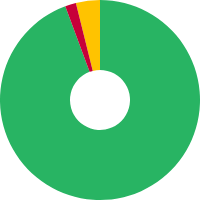
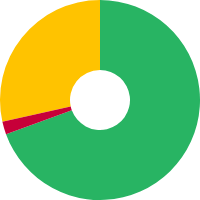
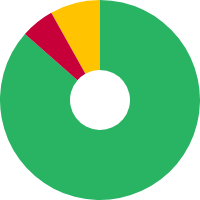
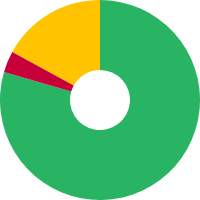
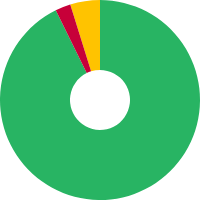
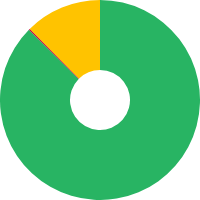
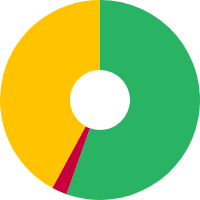
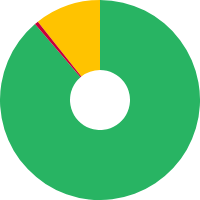
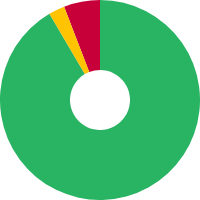
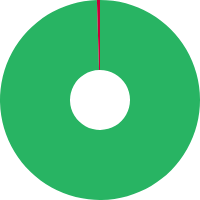
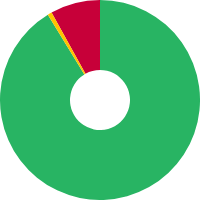
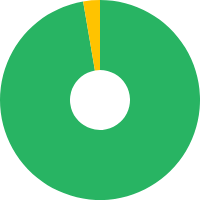
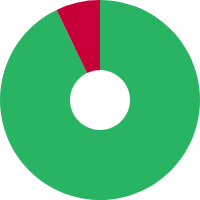
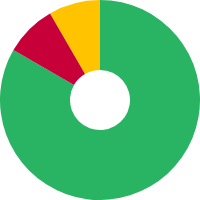
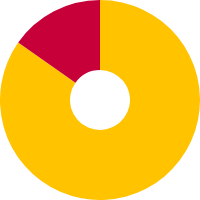
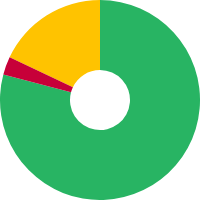
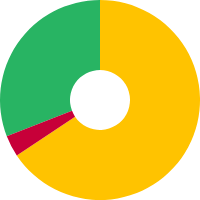
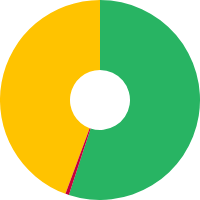
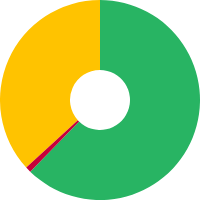
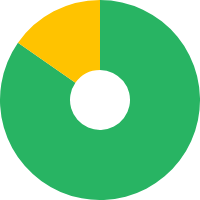
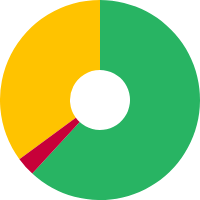
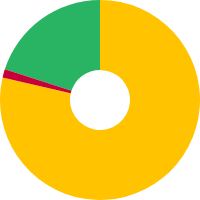
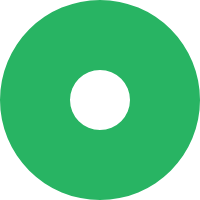
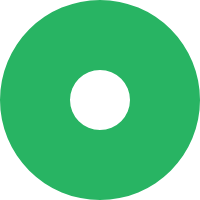
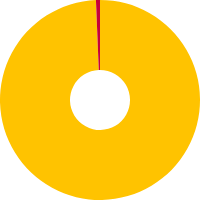
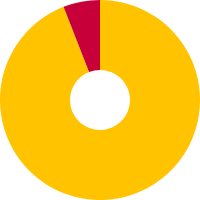
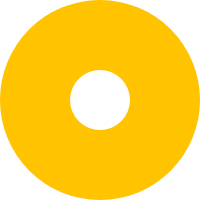
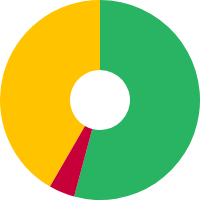
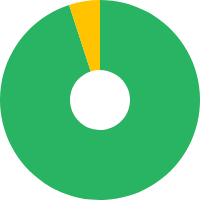
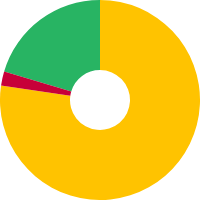
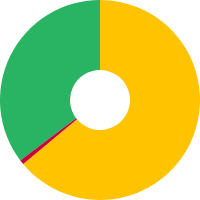
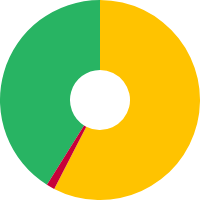
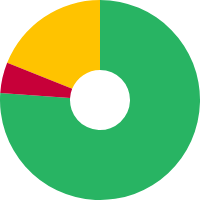
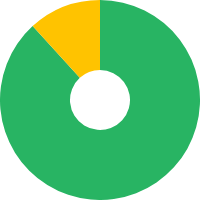
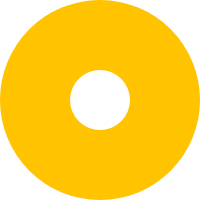
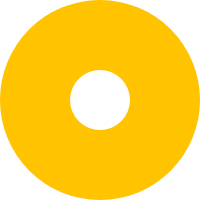
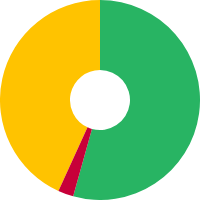
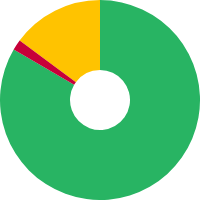
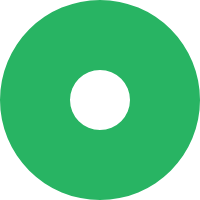
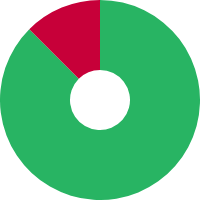
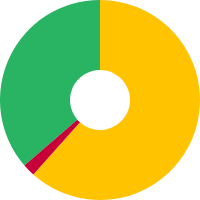
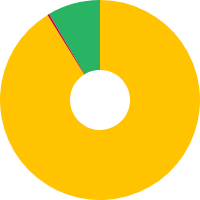
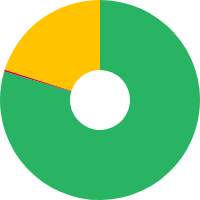
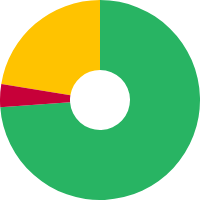
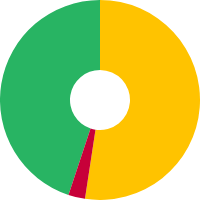
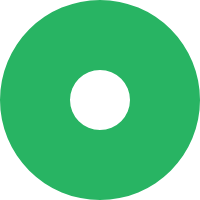
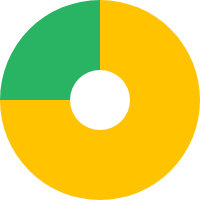
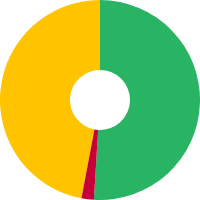
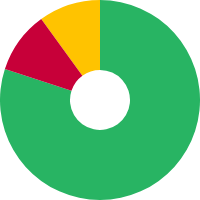
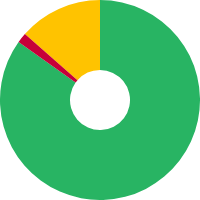
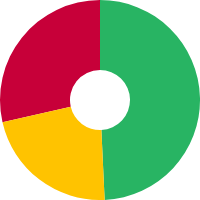
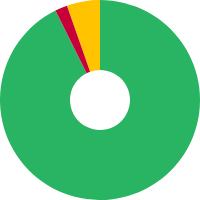
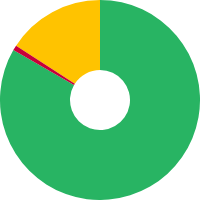
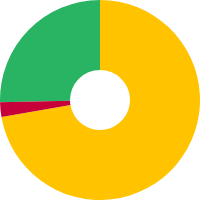

In [15]:
#Cell-7

# Step-4.2 > Geographical Heatmap of Active cases

import folium
from folium import plugins
import plotly.graph_objects as go
import base64
from PIL import Image
import io

# Data Preparation ---

latest_date = df['Date'].max()
df_latest = df[df['Date'] == latest_date].copy()

# Map Initialization -Create a base map, centered on the world
m = folium.Map(location=[20, 0], tiles='CartoDB positron', zoom_start=2)

# Helper Function to Scale Marker Size- We use a log scale to handle the vast range of case numbers
def scale_size(cases):
    if cases > 0:
        return np.log(cases + 1) * 4 # Adjust the multiplier (e.g., * 4) to change size
    return 0

# Main Loop to Create and Add Pie Chart Markers
for i, row in df_latest.iterrows():
    lat = row['Lat']
    lon = row['Long']
    location_name = row['Location']
    confirmed = row['Confirmed']
    active = row['Active']
    deaths = row['Deaths']
    recovered = row['Recovered']

    # Skip locations with no cases or missing coordinates
    if confirmed <= 0 or pd.isnull(lat) or pd.isnull(lon):
        continue

    # Define the data for the pie chart
    values = [active, deaths, recovered]
    labels = ['Active', 'Deaths', 'Recovered']
    colors = ['#FFC300', '#C70039', '#28B463'] # Yellow, Red, Green

    # Create a pie chart figure using Plotly
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, marker_colors=colors, hole=.3, textinfo='none')])
    fig.update_layout(
        showlegend=False,
        margin=dict(l=0, r=0, t=0, b=0),
        paper_bgcolor='rgba(0,0,0,0)', # Transparent background
        plot_bgcolor='rgba(0,0,0,0)'
    )

    # Convert the figure to a PNG image in memory
    img_bytes = fig.to_image(format="png", width=100, height=100, scale=2)

# Encode Image and Create HTML for the Icon
    encoded = base64.b64encode(img_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{encoded}" style="width: 100%; height: 100%; border-radius: 50%;">'

# Create Popup with Detailed Information ---
    popup_html = f"""
    <b>{location_name}</b><br>
    <hr>
    Confirmed: {int(confirmed):,}<br>
    Active: {int(active):,}<br>
    Deaths: {int(deaths):,}<br>
    Recovered: {int(recovered):,}<br>
    """
    popup = folium.Popup(popup_html, max_width=250)

# Add the Custom Marker to the Map ---
    folium.Marker(
        location=[lat, lon],
        icon=folium.DivIcon(
            icon_size=(scale_size(confirmed), scale_size(confirmed)),
            icon_anchor=(scale_size(confirmed)/2, scale_size(confirmed)/2),
            html=html
        ),
        popup=popup
    ).add_to(m)


# Add a Legend to the Map ---
legend_html = """
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 150px; height: 95px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:rgba(255, 255, 255, 0.9);
     border-radius: 5px;
     ">&nbsp; <b>Legend</b><br>
     &nbsp; <i class="fa fa-circle" style="color:#FFC300"></i>&nbsp; Active<br>
     &nbsp; <i class="fa fa-circle" style="color:#C70039"></i>&nbsp; Deaths<br>
     &nbsp; <i class="fa fa-circle" style="color:#28B463"></i>&nbsp; Recovered
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))


# Display the Final Map ---
m


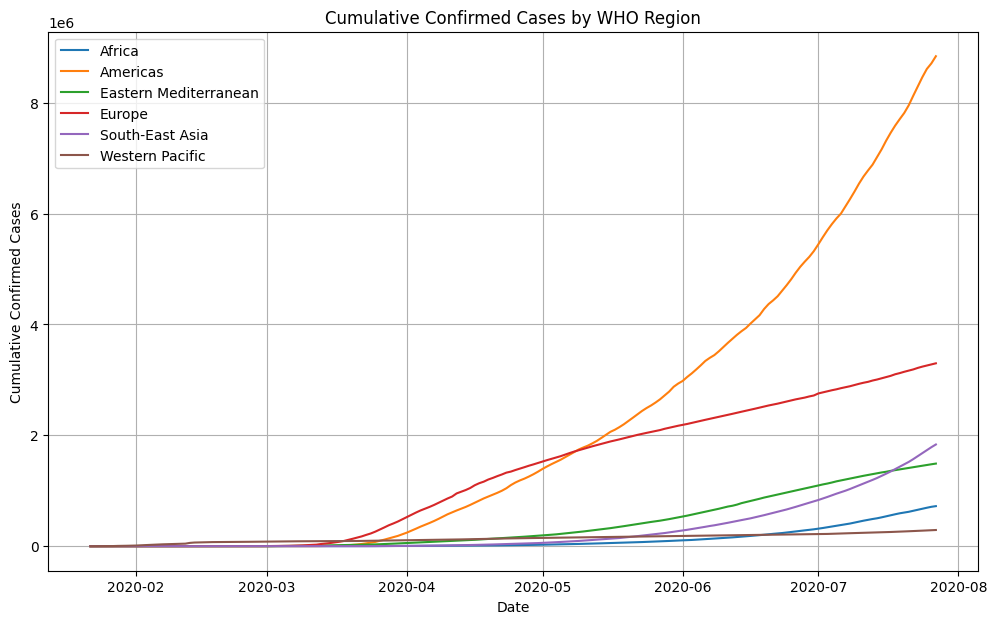

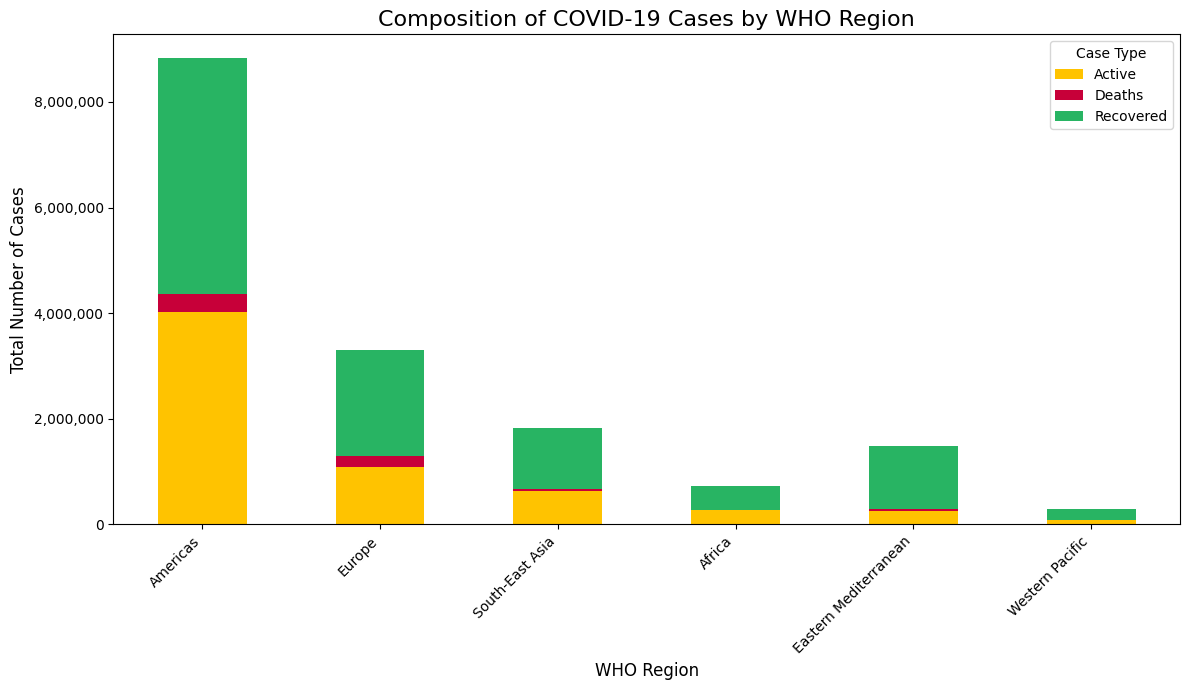

In [16]:
#Cell-8

# Step-4.3 > Cumulative Confirmed Cases by WHO Region

# Cumulative confirmed case as time is increasing
df_regional = df.groupby(['WHO Region', 'Date'])['Confirmed'].sum().reset_index()

plt.figure(figsize=(12, 7))

for region in df_regional['WHO Region'].unique():
    region_data = df_regional[df_regional['WHO Region'] == region]
    plt.plot(region_data['Date'], region_data['Confirmed'], label=region)

plt.title('Cumulative Confirmed Cases by WHO Region')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()


# Cumulative cases in Stacked Bar chart

latest_date = df['Date'].max()
df_latest = df[df['Date'] == latest_date]

df_regional_summary = df_latest.groupby('WHO Region')[['Active', 'Deaths', 'Recovered']].sum()
df_regional_summary = df_regional_summary.sort_values(by='Active', ascending=False)

df_regional_summary.plot(
    kind='bar',
    stacked=True,
    color=['#FFC300', '#C70039', '#28B463'], # Yellow, Red, Green
    figsize=(12, 7)
)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('Composition of COVID-19 Cases by WHO Region', fontsize=16)
plt.xlabel('WHO Region', fontsize=12)
plt.ylabel('Total Number of Cases', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Case Type')
plt.tight_layout()
plt.show()

# **4. Feature Enginnering for Deeper Analysis**

In [17]:
#Cell-9

# Step 4.4 > For Features like Mortality rate, Recovery rate and % daily addition

print("Starting the definitive data cleaning process...")

# Start with a fresh copy of the original DataFrame
df_clean = df.copy()

df_clean = df_clean.sort_values(by=['Location', 'Date'], ascending=True)

for col in ['Confirmed', 'Deaths', 'Recovered']:
    df_clean[col] = df_clean.groupby('Location')[col].cummax()

df_clean['Active'] = df_clean['Confirmed'] - df_clean['Deaths'] - df_clean['Recovered']
df_clean['Active'] = df_clean['Active'].clip(lower=0)
print("Data cleaning is complete. The 'df_clean' DataFrame is now ready. ✅")

Starting the definitive data cleaning process...
Data cleaning is complete. The 'df_clean' DataFrame is now ready. ✅


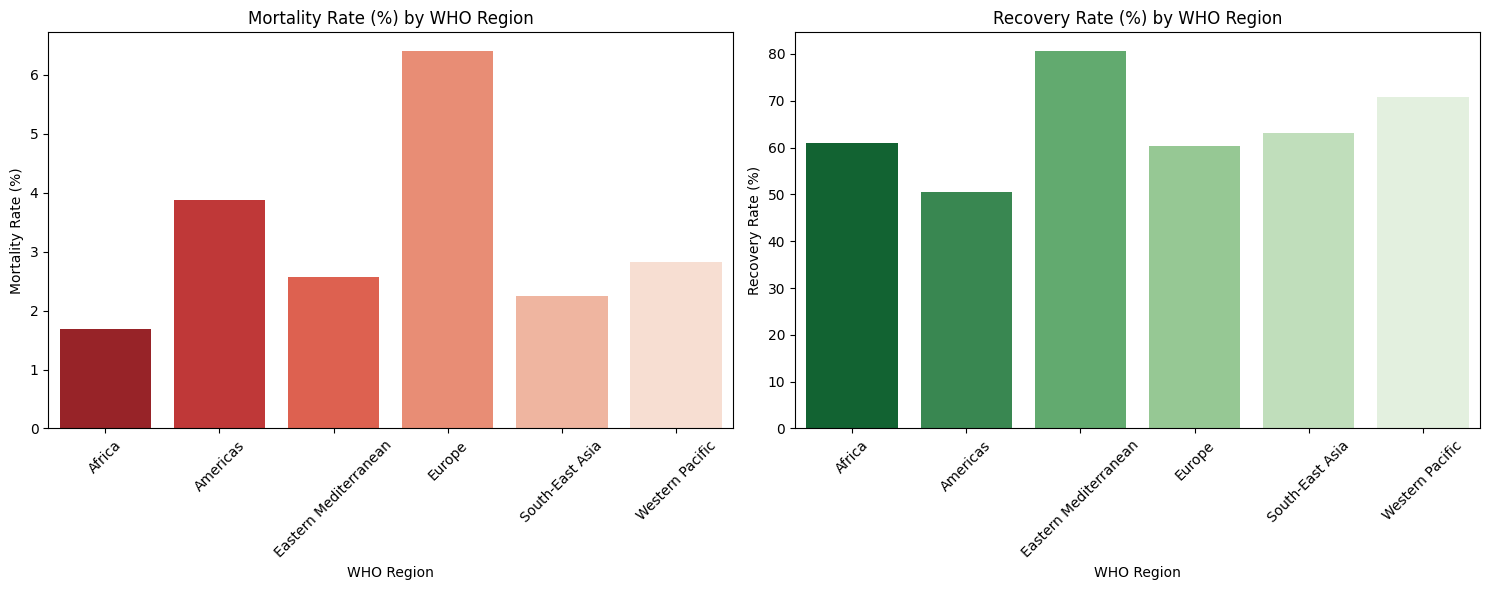

In [18]:
#Cell-10

# --- 1. Feature Engineering: Create Rate Columns ---

latest_date = df['Date'].max()

# Select only the numeric columns you need BEFORE summing
df_regional_summary = df[df['Date'] == latest_date].groupby('WHO Region')[['Confirmed', 'Deaths', 'Recovered']].sum()

# Calculate rates, handling division by zero by filling with 0
df_regional_summary['Mortality Rate'] = (df_regional_summary['Deaths'] / df_regional_summary['Confirmed']).fillna(0) * 100
df_regional_summary['Recovery Rate'] = (df_regional_summary['Recovered'] / df_regional_summary['Confirmed']).fillna(0) * 100

# --- 2. Plotting the Rates ---
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Mortality Rate
sns.barplot(x=df_regional_summary.index, y=df_regional_summary['Mortality Rate'], ax=ax[0], palette='Reds_r', hue=df_regional_summary.index, legend=False)
ax[0].set_title('Mortality Rate (%) by WHO Region')
ax[0].set_ylabel('Mortality Rate (%)')
ax[0].tick_params(axis='x', rotation=45)

# Plot Recovery Rate
sns.barplot(x=df_regional_summary.index, y=df_regional_summary['Recovery Rate'], ax=ax[1], palette='Greens_r', hue=df_regional_summary.index, legend=False)
ax[1].set_title('Recovery Rate (%) by WHO Region')
ax[1].set_ylabel('Recovery Rate (%)')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [19]:
#Cell-11

# Step 5 > Deliverable 1- Final Data Cleaning Pipeline

print("Executing the final data cleaning pipeline...")

df_clean = df.copy()

# Sort data by Location and Date to ensure correct chronological order.
df_clean = df_clean.sort_values(by=['Location', 'Date'], ascending=True)
print("Step 1: Data sorted by Location and Date.")

# Create the unified 'Location' column before dropping others.
df_clean['Province/State'].fillna('', inplace=True)
df_clean['Location'] = np.where(
    df_clean['Province/State'] != '',
    df_clean['Country/Region'] + ' - ' + df_clean['Province/State'],
    df_clean['Country/Region']
)
print("Step 2: Unified 'Location' column created.")


# Fix any downward revisions in cumulative data using .cummax().This ensures that the time series for these metrics is monotonically increasing.
for col in ['Confirmed', 'Deaths', 'Recovered']:
    df_clean[col] = df_clean.groupby('Location')[col].cummax()
print("Step 3: Downward data revisions for Confirmed, Deaths, and Recovered have been corrected.")

# Recalculate 'Active' cases using the newly cleaned data.
df_clean['Active'] = df_clean['Confirmed'] - df_clean['Deaths'] - df_clean['Recovered']
print("Step 4: 'Active' cases recalculated.")

# Final, crucial correction: Ensure 'Active' cases are never negative.
df_clean['Active'] = df_clean['Active'].clip(lower=0)
print("Step 5: Negative 'Active' case values have been corrected to 0.")

# Select and reorder columns for the final dataset.
final_columns = [
    'Location',
    'Date',
    'Lat',
    'Long',
    'Confirmed',
    'Deaths',
    'Recovered',
    'Active',
    'WHO Region'
]
df_clean = df_clean[final_columns]
print("Step 6: Final columns selected and reordered.")

print("\nDefinitive data cleaning is complete. The 'df_clean' DataFrame is now model-ready. ✅")

# Save the Final Dataset for Deliverable 1 ---
output_filename = 'COVID-19_Model_Ready_Dataset.csv'
df_clean.to_csv(output_filename, index=False)
print(f"Success! 🎉")
print(f"Your cleaned, model-ready dataset has been saved as '{output_filename}'.")
print("You can now download it from the file browser on the left.")



Executing the final data cleaning pipeline...
Step 1: Data sorted by Location and Date.
Step 2: Unified 'Location' column created.
Step 3: Downward data revisions for Confirmed, Deaths, and Recovered have been corrected.
Step 4: 'Active' cases recalculated.
Step 5: Negative 'Active' case values have been corrected to 0.
Step 6: Final columns selected and reordered.

Definitive data cleaning is complete. The 'df_clean' DataFrame is now model-ready. ✅


/tmp/ipython-input-1842967971.py:14: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Success! 🎉
Your cleaned, model-ready dataset has been saved as 'COVID-19_Model_Ready_Dataset.csv'.
You can now download it from the file browser on the left.


# **5. HyperParameter Tuning for LSTM, ARIMA, SARIMA, Polynomial Regression**

In [20]:
#Cell-12

import pandas as pd
import numpy as np
import warnings
import time
import itertools
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 0. Data Preparation (Example: Europe) ---
# This entire script is a methodology. We use 'Europe' as a concrete example.
print("--- Preparing data for Europe ---")
europe_df = df_clean[df_clean['WHO Region'] == 'Europe'].groupby('Date').sum()
time_series = europe_df['Confirmed']

# ==============================================================================
# Method 1: Tuning Polynomial Regression
# ==============================================================================
def tune_polynomial_regression(series):
    """Finds the best polynomial degree using time-series cross-validation."""
    print("\n--- Tuning Polynomial Regression ---")
    X = np.arange(len(series)).reshape(-1, 1)
    y = series.values

    best_degree = -1
    best_rmse = np.inf

    # We will test degrees from 2 to 8
    for degree in range(2, 9):
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)

        # Use TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=3)
        current_rmse = []
        for train_index, val_index in tscv.split(X_poly):
            X_train, X_val = X_poly[train_index], X_poly[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = LinearRegression().fit(X_train, y_train)
            preds = model.predict(X_val)
            current_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

        avg_rmse = np.mean(current_rmse)
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_degree = degree

    print(f"Best Polynomial Degree: {best_degree} (Validation RMSE: {int(best_rmse):,})")
    return best_degree

# ==============================================================================
# Method 2: Tuning SARIMA with Random Search
# ==============================================================================
def tune_sarima_random_search(series, n_iterations=20):
    """Finds good SARIMA parameters using a manual random search."""
    print("\n--- Tuning SARIMA with Random Search ---")
    log_series = np.log(series + 1)

    # Define parameter ranges
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

    # Create a list of all possible combinations
    all_params = list(itertools.product(pdq, seasonal_pdq))
    # Randomly sample from the combinations
    random_params = np.random.choice(len(all_params), n_iterations, replace=False)

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for i in random_params:
        param, param_seasonal = all_params[i]
        try:
            temp_model = SARIMAX(log_series, order=param, seasonal_order=param_seasonal).fit(disp=False)
            if temp_model.aic < best_aic:
                best_aic = temp_model.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

    print(f"Best SARIMA Order found: {best_order}")
    print(f"Best Seasonal Order found: {best_seasonal_order}")
    print(f"AIC: {best_aic:.2f}")
    return best_order, best_seasonal_order

# ==============================================================================
# Method 3: Tuning LSTM with Random Search
# ==============================================================================
def tune_lstm_random_search(series, n_iterations=10):
    """Finds good LSTM hyperparameters using a simplified random search."""
    print("\n--- Tuning LSTM with Random Search ---")

    # --- Define Hyperparameter Search Space ---
    param_grid = {
        'look_back': [7, 14],
        'neurons': [32, 50, 64],
        'epochs': [25, 50],
        'batch_size': [1, 16]
    }

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))

    best_params = {}
    best_rmse = np.inf

    for i in range(n_iterations):
        # --- FIX: Convert NumPy types to standard Python integers ---
        params = {key: int(np.random.choice(values)) for key, values in param_grid.items()}
        # -------------------------------------------------------------
        print(f"Iteration {i+1}/{n_iterations} | Testing params: {params}")

        # Create sequences
        look_back = params['look_back']
        X, y = [], []
        for j in range(len(scaled_series) - look_back):
            X.append(scaled_series[j:(j+look_back), 0])
            y.append(scaled_series[j + look_back, 0])
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        # Split data for validation
        train_size = int(len(X) * 0.8)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]

        # Build and train model
        model = Sequential([
            LSTM(params['neurons'], input_shape=(look_back, 1)),
            Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

        # Evaluate
        val_pred_scaled = model.predict(X_val)
        val_pred = scaler.inverse_transform(val_pred_scaled)
        y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
        current_rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred))

        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_params = params

    print(f"\nBest LSTM Params: {best_params} (Validation RMSE: {int(best_rmse):,})")
    return best_params

# --- Execute the Tuning Engine ---
best_poly_degree = tune_polynomial_regression(time_series)
best_sarima_order, best_seasonal_order = tune_sarima_random_search(time_series)
best_lstm_params = tune_lstm_random_search(time_series)


--- Preparing data for Europe ---

--- Tuning Polynomial Regression ---
Best Polynomial Degree: 2 (Validation RMSE: 870,579)

--- Tuning SARIMA with Random Search ---
Best SARIMA Order found: (2, 2, 1)
Best Seasonal Order found: (0, 0, 1, 7)
AIC: -354.92

--- Tuning LSTM with Random Search ---
Iteration 1/10 | Testing params: {'look_back': 7, 'neurons': 50, 'epochs': 25, 'batch_size': 1}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Iteration 2/10 | Testing params: {'look_back': 7, 'neurons': 64, 'epochs': 25, 'batch_size': 1}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Iteration 3/10 | Testing params: {'look_back': 7, 'neurons': 64, 'epochs': 25, 'batch_size': 1}


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Iteration 4/10 | Testing params: {'look_back': 7, 'neurons': 32, 'epochs': 50, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Iteration 5/10 | Testing params: {'look_back': 7, 'neurons': 32, 'epochs': 25, 'batch_size': 1}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Iteration 6/10 | Testing params: {'look_back': 7, 'neurons': 32, 'epochs': 50, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Iteration 7/10 | Testing params: {'look_back': 14, 'neurons': 50, 'epochs': 25, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Iteration 8/10 | Testing params: {'look_back': 14, 'neurons': 64, 'epochs': 50, 'batch_size': 1}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Iteration 9/10 | Testing params: {'look_back': 14, 'neurons': 64, 'epochs': 25, 'batch_size': 1}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Iteration 10/10 | Testing params: {'look_back': 14, 'neurons': 64, 'epochs': 25, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

Best L

# **6. HEURICSTIC APPROCH TO REACH OPTIMASTION**

#Polynomial Iterations

Model-1 > Fitting Polynomial Regression Models for All WHO Regions 
Region: Eastern Mediterranean | Polynomial Regression RMSE: 325,965
Region: Europe | Polynomial Regression RMSE: 1,375,980
Region: Africa | Polynomial Regression RMSE: 65,395
Region: Americas | Polynomial Regression RMSE: 1,333,167
Region: Western Pacific | Polynomial Regression RMSE: 89,185
Region: South-East Asia | Polynomial Regression RMSE: 18,955


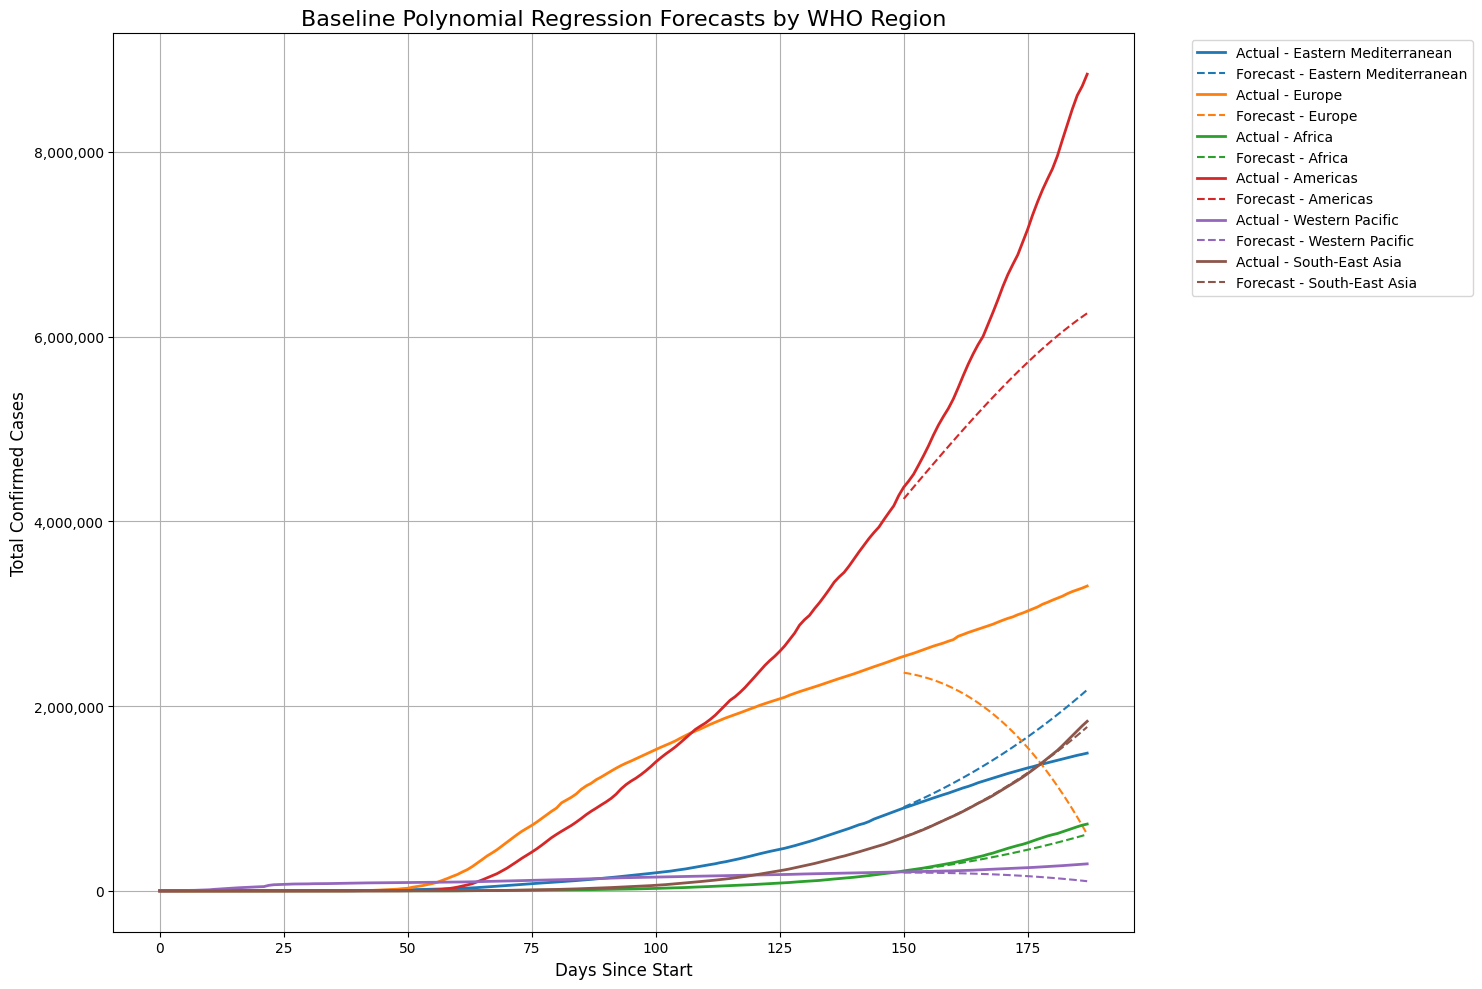

In [21]:
#Cell-13

# Step - 6 > Model 1: Polynomial Regression

# Create a color palette to assign a unique color to each WHO region
regions = df_clean['WHO Region'].unique()
colors = sns.color_palette('tab10', len(regions))
region_color_map = dict(zip(regions, colors))

# --- 1.Initialize the plot---
plt.figure(figsize=(15, 10))
ax = plt.gca()

print("Model-1 > Fitting Polynomial Regression Models for All WHO Regions ")

# --- 2. Loop Through Each WHO Region ---
for region in regions:
    # --- Data Preparation for the current region ---
    region_df = df_clean[df_clean['WHO Region'] == region].groupby('Date').sum().reset_index()

    # --- Feature Engineering ---
    region_df['Day_Num'] = np.arange(len(region_df))
    X = region_df[['Day_Num']]
    y = region_df['Confirmed']

    # --- Train-Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # --- Polynomial Regression Model ---
    # Create polynomial features (degree=4 for a better fit to diverse curves)
    poly = PolynomialFeatures(degree=4)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Fit the model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # Make predictions
    poly_predictions = poly_model.predict(X_test_poly)
    poly_rmse = np.sqrt(mean_squared_error(y_test, poly_predictions))
    print(f"Region: {region} | Polynomial Regression RMSE: {int(poly_rmse):,}")

    # --- Visualization ---
    # Plot the actual data for the region
    plt.plot(region_df['Day_Num'], y, label=f'Actual - {region}', color=region_color_map[region], linewidth=2)
    # Plot the forecast for the region
    plt.plot(X_test['Day_Num'], poly_predictions, color=region_color_map[region], linestyle='--', label=f'Forecast - {region}')


# --- 3. Final Plot Formatting ---
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('Baseline Polynomial Regression Forecasts by WHO Region', fontsize=16)
plt.xlabel('Days Since Start', fontsize=12)
plt.ylabel('Total Confirmed Cases', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


#ARIMA MODELLING

--- Preparing data for India ---

--- Stationarity Test on Log-Transformed Data ---
ADF Statistic: -2.013801765480042
p-value: 0.2805544863715209
Data is not stationary.

--- Stationarity Test on Differenced Data ---
ADF Statistic: -7.493585956319406
p-value: 4.439381443610587e-11
Data is stationary.


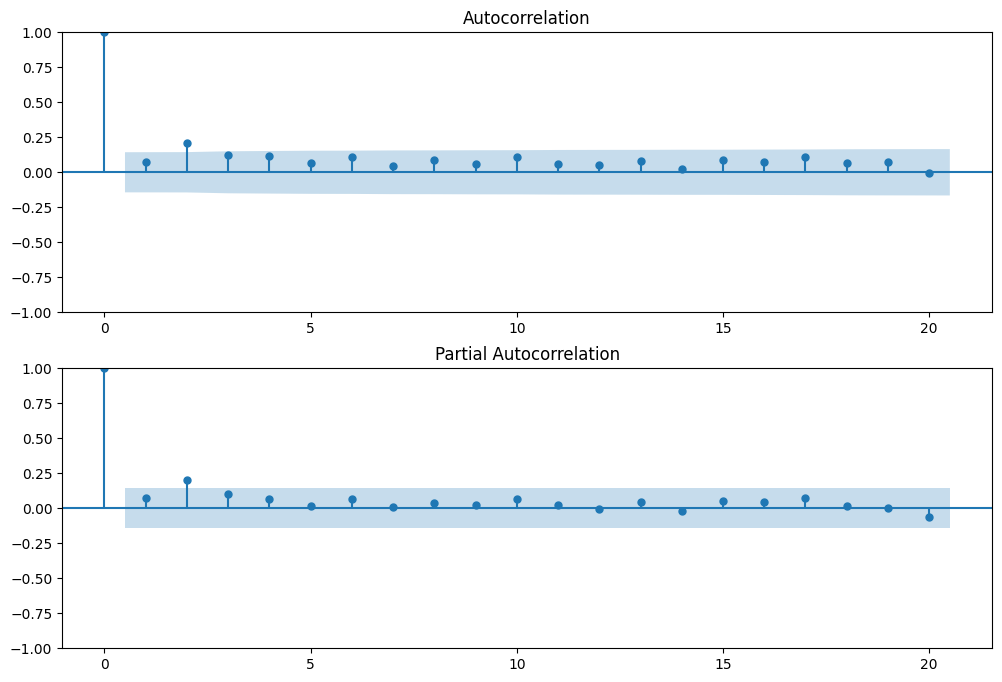


--- Fitting ARIMA(1, 1, 1) Model ---
                               SARIMAX Results                                
Dep. Variable:          Confirmed_Log   No. Observations:                  150
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  67.484
Date:                Wed, 06 Aug 2025   AIC                           -128.967
Time:                        16:27:08   BIC                           -119.956
Sample:                    01-22-2020   HQIC                          -125.306
                         - 06-19-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9862      0.036     27.142      0.000       0.915       1.057
ma.L1         -0.9029      0.097     -9.355      0.000      -1.092      -0.714
sigma2        

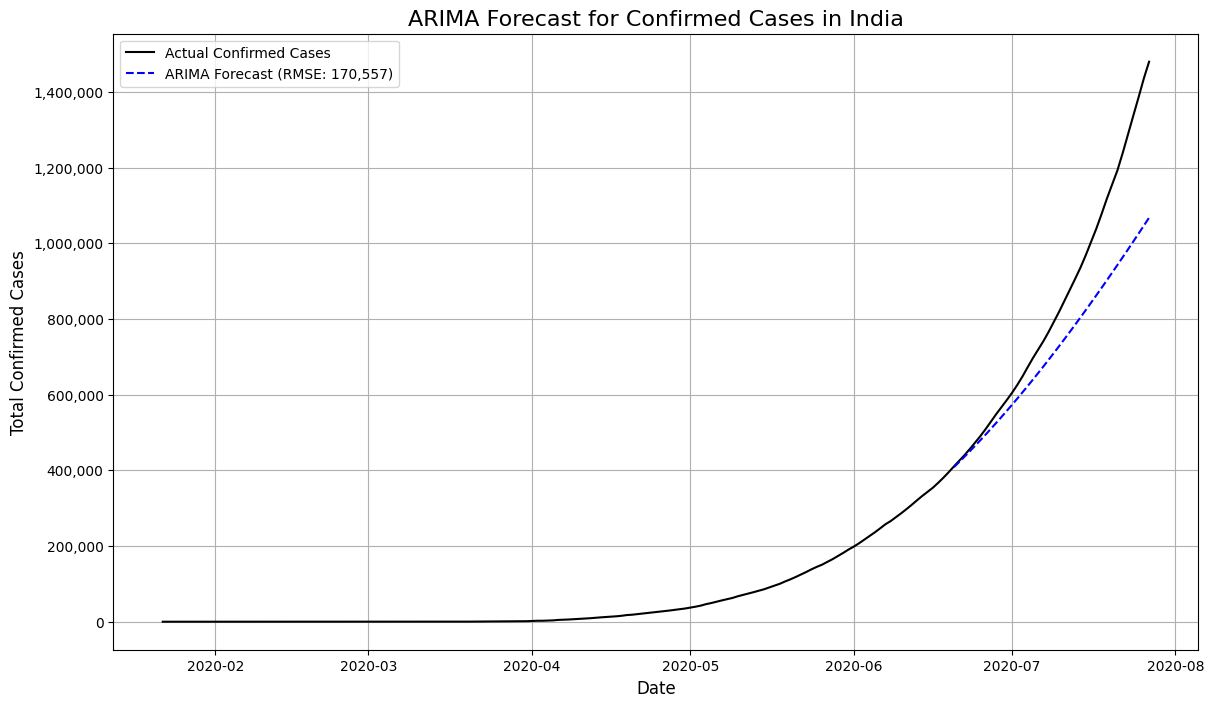

In [22]:
#Cell-14

# Step- 6> Model 2: ARIMA (INDIA)

print("--- Preparing data for India ---")
india_df = df_clean[df_clean['Location'] == 'India'].set_index('Date')

# ARIMA works best on data with stable variance. We apply a log transform. We add 1 to handle any zero values in 'Confirmed' cases.
india_df['Confirmed_Log'] = np.log(india_df['Confirmed'] + 1)

#  Check for Stationarity ---
# ARIMA requires the time series to be stationary (constant mean, variance, and autocorrelation).
# We use the Augmented Dickey-Fuller (ADF) test to check this.
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary.")

print("\n--- Stationarity Test on Log-Transformed Data ---")
adf_test(india_df['Confirmed_Log'])


#  Differencing to Achieve Stationarity ---
# Since the data is not stationary, we apply differencing.
# This calculates the difference between consecutive data points.
india_df['Confirmed_Log_Diff'] = india_df['Confirmed_Log'].diff().dropna()

print("\n--- Stationarity Test on Differenced Data ---")
adf_test(india_df['Confirmed_Log_Diff'].dropna())
# The p-value is now well below 0.05, so our data is stationary.
# We differenced once, so the 'd' parameter for our ARIMA model is 1.


#  Find ARIMA Parameters (p, d, q) ---
# d = 1 (from the differencing step)
# To find p and q, we plot the ACF and PACF.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(india_df['Confirmed_Log_Diff'].dropna(), ax=ax1, lags=20)
plot_pacf(india_df['Confirmed_Log_Diff'].dropna(), ax=ax2, lags=20)
plt.show()
# Interpretation:
# PACF plot shows a sharp cutoff after lag 1, suggesting p=1.
# ACF plot shows a more gradual decline, suggesting a moving average component. Let's start with q=1.
# So, our initial ARIMA order will be (p=1, d=1, q=1).


#  Build and Train the ARIMA Model ---
# We'll split the data into a training (80%) and testing (20%) set.
train_data = india_df['Confirmed_Log'][:int(len(india_df)*0.8)]
test_data = india_df['Confirmed_Log'][int(len(india_df)*0.8):]

# Initialize and fit the ARIMA model
print("\n--- Fitting ARIMA(1, 1, 1) Model ---")
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


#  Forecasting and Evaluation ---
# Make predictions on the test set period
predictions_log = model_fit.forecast(steps=len(test_data))

# Reverse the log transformation to get the actual predicted case numbers
predictions = np.exp(predictions_log)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(np.exp(test_data), predictions))
print(f"\nARIMA Model RMSE: {int(rmse):,}")


#  Visualization ---
plt.figure(figsize=(14, 8))
plt.plot(india_df.index, india_df['Confirmed'], label='Actual Confirmed Cases', color='black')
plt.plot(predictions.index, predictions, label=f'ARIMA Forecast (RMSE: {int(rmse):,})', color='blue', linestyle='--')

# Formatting
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('ARIMA Forecast for Confirmed Cases in India', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Confirmed Cases', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


--- Building ARIMA Models for All WHO Regions ---

--- Processing Region: Eastern Mediterranean ---
ARIMA Model RMSE for Eastern Mediterranean: 90,997

--- Processing Region: Europe ---
ARIMA Model RMSE for Europe: 79,005

--- Processing Region: Africa ---
ARIMA Model RMSE for Africa: 128,979

--- Processing Region: Americas ---
ARIMA Model RMSE for Americas: 719,700

--- Processing Region: Western Pacific ---
ARIMA Model RMSE for Western Pacific: 24,238

--- Processing Region: South-East Asia ---
ARIMA Model RMSE for South-East Asia: 31,485


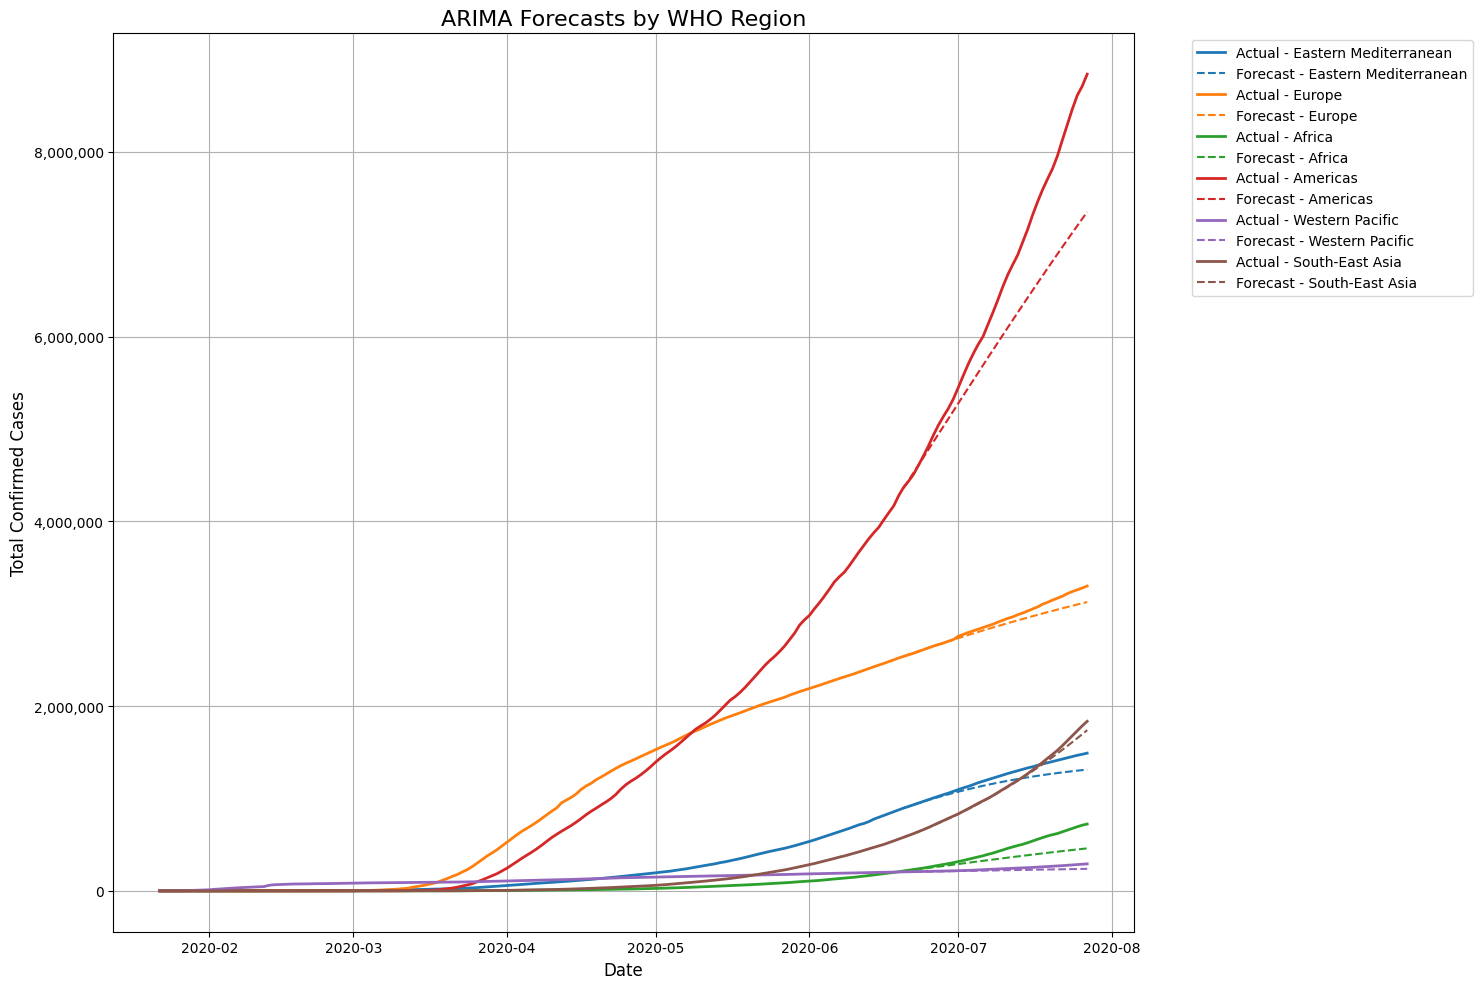

In [23]:
#Cell-15

# Step- 6> Model 2: ARIMA (WHO Level)

# --- 1. Setup for Plotting All Regions ---

regions = df_clean['WHO Region'].unique()
colors = sns.color_palette('tab10', len(regions))
region_color_map = dict(zip(regions, colors))

# Initialize the plot
plt.figure(figsize=(15, 10))
ax = plt.gca()

print("--- Building ARIMA Models for All WHO Regions ---")

# --- 2. Loop Through Each WHO Region ---
for region in regions:
    print(f"\n--- Processing Region: {region} ---")

    # --- Data Preparation for the current region ---
    region_df = df_clean[df_clean['WHO Region'] == region].groupby('Date').sum().reset_index().set_index('Date')

    # Skip regions with very little data to avoid errors
    if len(region_df) < 50:
        print(f"Skipping {region} due to insufficient data.")
        continue

    region_df['Confirmed_Log'] = np.log(region_df['Confirmed'] + 1)

    # --- Stationarity and Differencing ---
    # We'll assume d=1 is sufficient for all regions based on prior analysis
    region_df['Confirmed_Log_Diff'] = region_df['Confirmed_Log'].diff().dropna()

    # --- Build and Train the ARIMA Model ---
    # We will use a generic ARIMA(1,1,1) model as a starting point for all regions.
    # For a real-world project, you would tune p and q for each region individually.
    train_data = region_df['Confirmed_Log'][:int(len(region_df)*0.8)]
    test_data = region_df['Confirmed_Log'][int(len(region_df)*0.8):]

    try:
        model = ARIMA(train_data, order=(1, 1, 1))
        model_fit = model.fit()

        # --- Forecasting and Evaluation ---
        predictions_log = model_fit.forecast(steps=len(test_data))
        predictions = np.exp(predictions_log)
        rmse = np.sqrt(mean_squared_error(np.exp(test_data), predictions))
        print(f"ARIMA Model RMSE for {region}: {int(rmse):,}")

        # --- Visualization ---
        # Plot the actual data for the region
        plt.plot(region_df.index, region_df['Confirmed'], label=f'Actual - {region}', color=region_color_map[region], linewidth=2)
        # Plot the forecast for the region
        plt.plot(predictions.index, predictions, color=region_color_map[region], linestyle='--', label=f'Forecast - {region}')

    except Exception as e:
        print(f"Could not fit ARIMA model for {region}. Error: {e}")


# --- 3. Final Plot Formatting ---
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('ARIMA Forecasts by WHO Region', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Confirmed Cases', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


#SARIMAX MODELLING

--- Building SARIMA Models for All WHO Regions ---

--- Processing Region: Eastern Mediterranean ---
SARIMA Model RMSE for Eastern Mediterranean: 165,958

--- Processing Region: Europe ---
SARIMA Model RMSE for Europe: 193,704

--- Processing Region: Africa ---
SARIMA Model RMSE for Africa: 127,235

--- Processing Region: Americas ---
SARIMA Model RMSE for Americas: 1,085,413

--- Processing Region: Western Pacific ---
SARIMA Model RMSE for Western Pacific: 20,253

--- Processing Region: South-East Asia ---
SARIMA Model RMSE for South-East Asia: 176,033


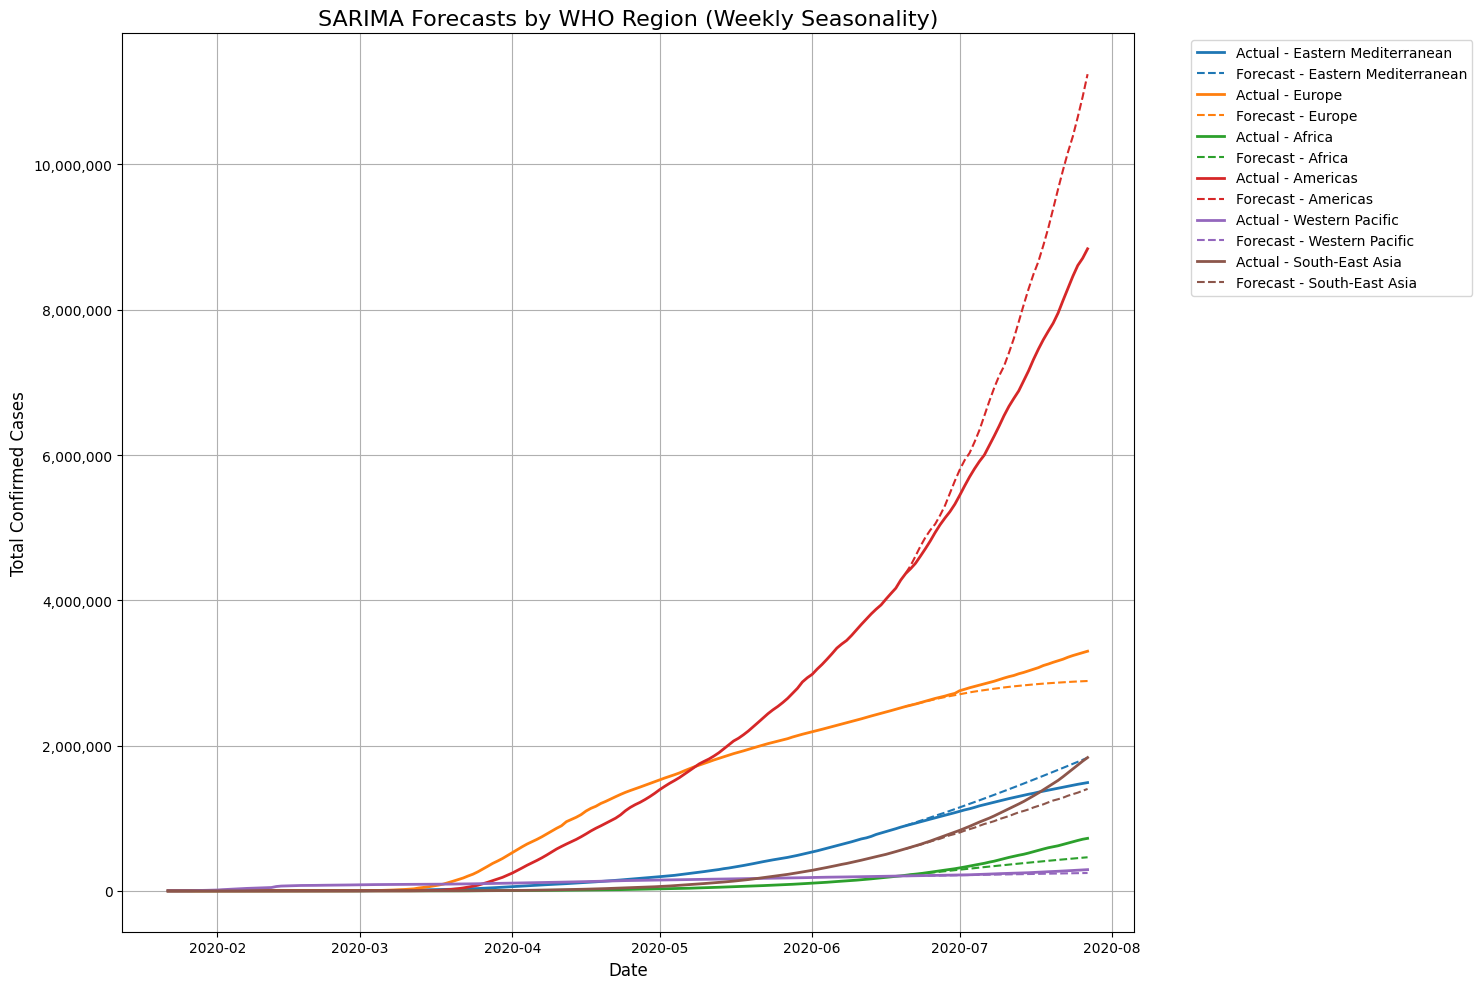

In [24]:
#Cell-16

# Step- 6> Model 3: SARIMAx (WHO Level)

# Suppress warnings from SARIMAX to keep the output clean
warnings.filterwarnings("ignore")

# --- 1. Setup for Plotting All Regions ---
# Create a color palette for unique colors per region
regions = df_clean['WHO Region'].unique()
colors = sns.color_palette('tab10', len(regions))
region_color_map = dict(zip(regions, colors))

# Initialize the plot
plt.figure(figsize=(15, 10))
ax = plt.gca()

print("--- Building SARIMA Models for All WHO Regions ---")

# --- 2. Loop Through Each WHO Region ---
for region in regions:
    print(f"\n--- Processing Region: {region} ---")

    # --- Data Preparation ---
    region_df = df_clean[df_clean['WHO Region'] == region].groupby('Date').sum().reset_index().set_index('Date')

    if len(region_df) < 50:
        print(f"Skipping {region} due to insufficient data.")
        continue

    region_df['Confirmed_Log'] = np.log(region_df['Confirmed'] + 1)

    # --- Train-Test Split ---
    train_data = region_df['Confirmed_Log'][:int(len(region_df)*0.8)]
    test_data = region_df['Confirmed_Log'][int(len(region_df)*0.8):]

    try:
        # --- Build and Train the SARIMA Model ---
        # We use order=(1,1,1) for non-seasonal components (like in ARIMA)
        # We use seasonal_order=(1,1,1,7) to capture weekly seasonality (s=7)
        model = SARIMAX(train_data,
                        order=(1, 1, 1),
                        seasonal_order=(1, 0, 2, 7))
        model_fit = model.fit(disp=False) # disp=False turns off convergence messages

        # --- Forecasting and Evaluation ---
        predictions_log = model_fit.forecast(steps=len(test_data))
        predictions = np.exp(predictions_log)
        rmse = np.sqrt(mean_squared_error(np.exp(test_data), predictions))
        print(f"SARIMA Model RMSE for {region}: {int(rmse):,}")

        # --- Visualization ---
        # Plot the actual data
        plt.plot(region_df.index, region_df['Confirmed'], label=f'Actual - {region}', color=region_color_map[region], linewidth=2)
        # Plot the SARIMA forecast
        plt.plot(predictions.index, predictions, color=region_color_map[region], linestyle='--', label=f'Forecast - {region}')

    except Exception as e:
        print(f"Could not fit SARIMA model for {region}. Error: {e}")


# --- 3. Final Plot Formatting ---
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('SARIMA Forecasts by WHO Region (Weekly Seasonality)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Confirmed Cases', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


LSTM MODELLING

--- Preparing data for the Americas region ---

--- Building and Training LSTM Model ---
Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0261
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0042
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.9394e-04
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9698e-04
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0957e-04
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1024e-04
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.9252e-05
Epoch 9/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.7058e-05
Epoch 10/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.9833e-05
Epoch 11/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5720e-05
Epoch 12/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2239e-05
Epoch 13/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.1055e-05
Epoch 14/25
9/9 ━━━━━━━━━━━━━━━━━━━

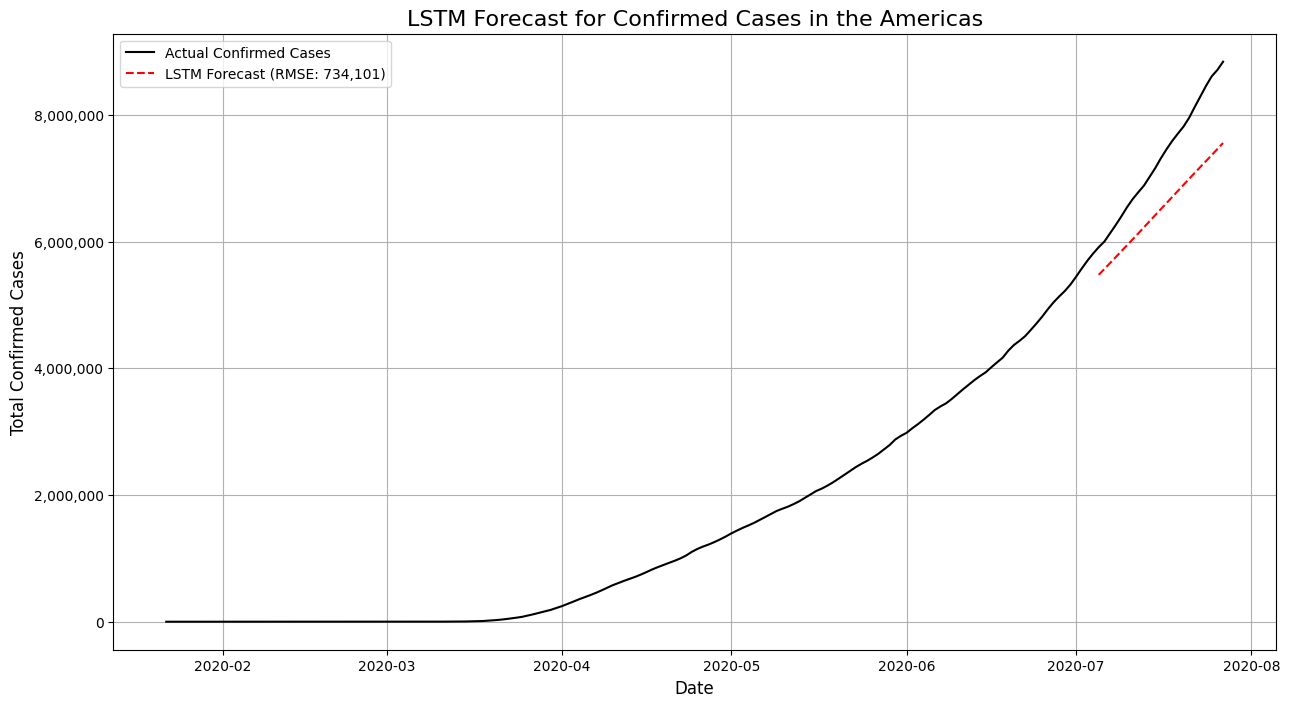

In [25]:
#Cell-17

# --- 1. Data Preparation for LSTM ---
# We'll use the 'Americas' WHO Region as our example to demonstrate the methodology
print("--- Preparing data for the Americas region ---")
americas_df = df_clean[df_clean['WHO Region'] == 'Americas'].groupby('Date').sum().reset_index()
confirmed_cases = americas_df['Confirmed'].values.reshape(-1, 1)

# Step A: Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_cases = scaler.fit_transform(confirmed_cases)

# Step B: Split data into training and testing sets (80/20 split)
train_size = int(len(scaled_cases) * 0.8)
train_data, test_data = scaled_cases[0:train_size,:], scaled_cases[train_size:len(scaled_cases),:]

# Step C: Create sequences (e.g., use last 7 days to predict the next day)
def create_sequences(dataset, look_back=7):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# --- Using a robust, pre-defined look_back period ---
look_back = 14
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

# Reshape input to be [samples, time steps, features] as required by LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# --- 2. Build and Train the LSTM Model ---
# We are using a standard, robust architecture for this demonstration
print("\n--- Building and Training LSTM Model ---")
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model with a standard number of epochs
model.fit(X_train, y_train, epochs=25, batch_size=16, verbose=1)


# --- 3. Forecasting and Evaluation ---
# Make predictions
test_predict = model.predict(X_test)

# Invert predictions back to original scale
test_predict = scaler.inverse_transform(test_predict)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predict))
print(f"\nTesting RMSE: {int(test_rmse):,}")


# --- 4. Visualization ---
plt.figure(figsize=(15, 8))

# Plot baseline data
plt.plot(americas_df['Date'], confirmed_cases, label='Actual Confirmed Cases', color='black')

# Plot predictions
predict_dates = americas_df['Date'][len(train_data)+look_back+1:len(confirmed_cases)]
plt.plot(predict_dates, test_predict, label=f'LSTM Forecast (RMSE: {int(test_rmse):,})', color='red', linestyle='--')

# Formatting
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('LSTM Forecast for Confirmed Cases in the Americas', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Confirmed Cases', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


CREATING PERFORMANCE METRICES FOR ALL MODELS- WHO Region LEVEL

In [26]:
#CEll-18

# Step- 7 > Model Performance Metrices-WHO Region Level

warnings.filterwarnings("ignore")

# --- 1. Helper function to calculate all metrics ---
def calculate_metrics(y_true, y_pred):
    """Calculates RMSE, MAE, and MAPE, handling potential zeros in y_true for MAPE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # Avoid division by zero for MAPE
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
    return {'RMSE': int(rmse), 'MAE': int(mae), 'MAPE': round(mape, 2)}

# --- 2. Initialize a list to store the results ---
results_list = []

# --- 3. Loop Through Each WHO Region ---
regions = df_clean['WHO Region'].unique()
for region in regions:
    print(f"--- Processing Region: {region} ---")

    # --- A. Data Preparation ---
    region_df = df_clean[df_clean['WHO Region'] == region].groupby('Date').sum().reset_index()
    if len(region_df) < 50: continue

    # --- B. Run All Models and Collect Metrics ---
    metrics_all_models = {'WHO Region': region}

    # -- Model 1: Polynomial Regression --
    try:
        X = np.arange(len(region_df)).reshape(-1, 1)
        y = region_df['Confirmed'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        poly = PolynomialFeatures(degree=2)
        X_train_poly, X_test_poly = poly.fit_transform(X_train), poly.transform(X_test)
        poly_model = LinearRegression().fit(X_train_poly, y_train)
        poly_pred = poly_model.predict(X_test_poly)
        metrics_all_models['Regression'] = calculate_metrics(y_test, poly_pred)
    except Exception:
        metrics_all_models['Regression'] = {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf}

    # -- Models 2 & 3: ARIMA & SARIMA --
    log_series = np.log(region_df['Confirmed'] + 1)
    train_log, test_log = log_series[:int(len(log_series)*0.8)], log_series[int(len(log_series)*0.8):]
    y_test_exp = np.exp(test_log)

    try:
        arima_model = ARIMA(train_log, order=(1, 1, 1)).fit()
        arima_pred = np.exp(arima_model.forecast(steps=len(test_log)))
        metrics_all_models['ARIMA'] = calculate_metrics(y_test_exp, arima_pred)
    except Exception:
        metrics_all_models['ARIMA'] = {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf}

    try:
        sarima_model = SARIMAX(train_log, order=(1, 1, 1), seasonal_order=(1, 0, 2, 7)).fit(disp=False)
        sarima_pred = np.exp(sarima_model.forecast(steps=len(test_log)))
        metrics_all_models['SARIMA'] = calculate_metrics(y_test_exp, sarima_pred)
    except Exception:
        metrics_all_models['SARIMA'] = {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf}

    # -- Model 4: LSTM --
    try:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_cases = scaler.fit_transform(y.reshape(-1, 1))
        train_data, test_data = scaled_cases[0:int(len(scaled_cases)*0.8)], scaled_cases[int(len(scaled_cases)*0.8):]

        def create_sequences(dataset, look_back=7):
            X, Y = [], []
            for i in range(len(dataset)-look_back-1): X.append(dataset[i:(i+look_back), 0]); Y.append(dataset[i + look_back, 0])
            return np.array(X), np.array(Y)

        X_train_lstm, y_train_lstm = create_sequences(train_data)
        X_test_lstm, y_test_lstm = create_sequences(test_data)
        X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
        X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

        lstm_model = Sequential([LSTM(5, input_shape=(7, 1)), Dense(1)])
        lstm_model.compile(loss='mean_squared_error', optimizer='adam')
        lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=1, verbose=0)

        lstm_pred_scaled = lstm_model.predict(X_test_lstm)
        lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
        y_test_orig = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
        metrics_all_models['LSTM'] = calculate_metrics(y_test_orig, lstm_pred)
    except Exception:
        metrics_all_models['LSTM'] = {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf}

    results_list.append(metrics_all_models)
    print(f"Finished processing {region}.")

# --- 4. Create and Display the Final Comparison DataFrame ---
# Flatten the nested dictionary structure for a clear table
final_results = []
for item in results_list:
    row = {'WHO Region': item['WHO Region']}
    for model_name, metrics in item.items():
        if model_name != 'WHO Region':
            for metric_name, value in metrics.items():
                row[f'{model_name}_{metric_name}'] = value
    final_results.append(row)

results_df = pd.DataFrame(final_results).set_index('WHO Region')

# Display the full results table
print("\n--- Comprehensive Model Performance Comparison ---")
print(results_df)

# --- 5. Determine the Best Model for Each Metric ---
print("\n--- Best Performing Model by Metric ---")
best_models = {}
for metric in ['RMSE', 'MAE', 'MAPE']:
    metric_cols = [col for col in results_df.columns if col.endswith(metric)]
    best_models[f'Best Model ({metric})'] = results_df[metric_cols].idxmin(axis=1).str.replace(f'_{metric}', '')

best_models_df = pd.DataFrame(best_models)
print(best_models_df)



--- Processing Region: Eastern Mediterranean ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Finished processing Eastern Mediterranean.
--- Processing Region: Europe ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Finished processing Europe.
--- Processing Region: Africa ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Finished processing Africa.
--- Processing Region: Americas ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Finished processing Americas.
--- Processing Region: Western Pacific ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Finished processing Western Pacific.
--- Processing Region: South-East Asia ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Finished processing South-East Asia.

--- Comprehensive Model Performance Comparison ---
                       Regression_RMSE  Regression_MAE  Regression_MAPE  \
WHO Region                                                                
Eastern Mediterranean           107536          105410             8.97   
Europe                          737269         

In [27]:
#CEll-19

# Step- 7 > Model Performance Metrices-Country Level

# Suppress warnings from models to keep the output clean
warnings.filterwarnings("ignore")

# --- 1. Helper function to calculate all metrics ---
def calculate_metrics(y_true, y_pred):
    """Calculates RMSE, MAE, and MAPE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
    return {'RMSE': int(rmse), 'MAE': int(mae), 'MAPE': round(mape, 2)}

# --- 2. Initialize a list to store the results ---
results_list = []
locations = df_clean['Location'].unique()

print(f"--- Starting Model Comparison for {len(locations)} Locations ---")

# --- 3. Loop Through Each Location ---
for i, location in enumerate(locations):
    # --- A. Data Preparation ---
    location_df = df_clean[df_clean['Location'] == location].reset_index()

    # We need enough data points to train and test the models
    if len(location_df) < 30:
        continue

    # Progress update
    if (i + 1) % 10 == 0:
        print(f"Processing location {i+1} of {len(locations)}: {location}")

    # --- B. Run Models and Collect Metrics ---
    metrics_all_models = {'Location': location}

    # -- Model 1: Polynomial Regression --
    try:
        X = np.arange(len(location_df)).reshape(-1, 1)
        y = location_df['Confirmed'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        poly = PolynomialFeatures(degree=2)
        X_train_poly, X_test_poly = poly.fit_transform(X_train), poly.transform(X_test)
        poly_model = LinearRegression().fit(X_train_poly, y_train)
        poly_pred = poly_model.predict(X_test_poly)
        metrics_all_models['Regression'] = calculate_metrics(y_test, poly_pred)
    except Exception:
        metrics_all_models['Regression'] = {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf}

    # -- Models 2 & 3: ARIMA & SARIMA --
    log_series = np.log(location_df['Confirmed'] + 1)
    train_log, test_log = log_series[:int(len(log_series)*0.8)], log_series[int(len(log_series)*0.8):]
    y_test_exp = np.exp(test_log)

    try:
        arima_model = ARIMA(train_log, order=(1, 1, 1)).fit()
        arima_pred = np.exp(arima_model.forecast(steps=len(test_log)))
        metrics_all_models['ARIMA'] = calculate_metrics(y_test_exp, arima_pred)
    except Exception:
        metrics_all_models['ARIMA'] = {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf}

    try:
        sarima_model = SARIMAX(train_log, order=(1, 1, 1), seasonal_order=(1, 0, 2, 7)).fit(disp=False)
        sarima_pred = np.exp(sarima_model.forecast(steps=len(test_log)))
        metrics_all_models['SARIMA'] = calculate_metrics(y_test_exp, sarima_pred)
    except Exception:
        metrics_all_models['SARIMA'] = {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf}

    results_list.append(metrics_all_models)

# --- 4. Create and Display the Final Comparison DataFrame ---
final_results = []
for item in results_list:
    row = {'Location': item['Location']}
    for model_name, metrics in item.items():
        if model_name != 'Location':
            for metric_name, value in metrics.items():
                row[f'{model_name}_{metric_name}'] = value
    final_results.append(row)

results_df_country = pd.DataFrame(final_results).set_index('Location')

# --- 5. Determine the Best Model for Each Metric ---
print("\n--- Best Performing Model by Metric (Country-Level) ---")
best_models_country = {}
for metric in ['RMSE', 'MAE', 'MAPE']:
    metric_cols = [col for col in results_df_country.columns if col.endswith(metric)]
    best_models_country[f'Best Model ({metric})'] = results_df_country[metric_cols].idxmin(axis=1).str.replace(f'_{metric}', '')

best_models_df_country = pd.DataFrame(best_models_country)

# Display the summary of best models
print(best_models_df_country)

# Display the first 15 rows of the full results table
print("\n--- Full Country-Level Performance Comparison (First 15 Rows) ---")
print(results_df_country.head(15))


--- Starting Model Comparison for 261 Locations ---
Processing location 10 of 261: Australia - New South Wales
Processing location 20 of 261: Bahrain
Processing location 30 of 261: Botswana
Processing location 40 of 261: Canada - Alberta
Processing location 50 of 261: Canada - Saskatchewan
Processing location 60 of 261: China - Guangdong
Processing location 70 of 261: China - Inner Mongolia
Processing location 80 of 261: China - Shanghai
Processing location 90 of 261: Congo (Brazzaville)
Processing location 100 of 261: Djibouti
Processing location 110 of 261: Ethiopia
Processing location 120 of 261: France - Reunion
Processing location 130 of 261: Greenland - Greenland
Processing location 140 of 261: Iceland
Processing location 150 of 261: Jordan
Processing location 160 of 261: Liberia
Processing location 170 of 261: Malta
Processing location 180 of 261: Namibia
Processing location 190 of 261: North Macedonia
Processing location 200 of 261: Portugal
Processing location 210 of 261: Saud

# **7. Forecasting Results**

#For Country Level

--- Final 60-Day Forecast Generation ... ---

--- Location: India  Forecast... ---
Best model : SARIMA

--- Location: US  Forecast... ---
Best model : Regression

--- Location: Italy  Forecast... ---
Best model : SARIMA

--- Location: Brazil  Forecast... ---
Best model : ARIMA

--- Location: South Africa  Forecast... ---
Best model : SARIMA

--- Location: Europe  Forecast... ---
Best model : SARIMA

--- Location: Americas  Forecast... ---
Best model : SARIMA


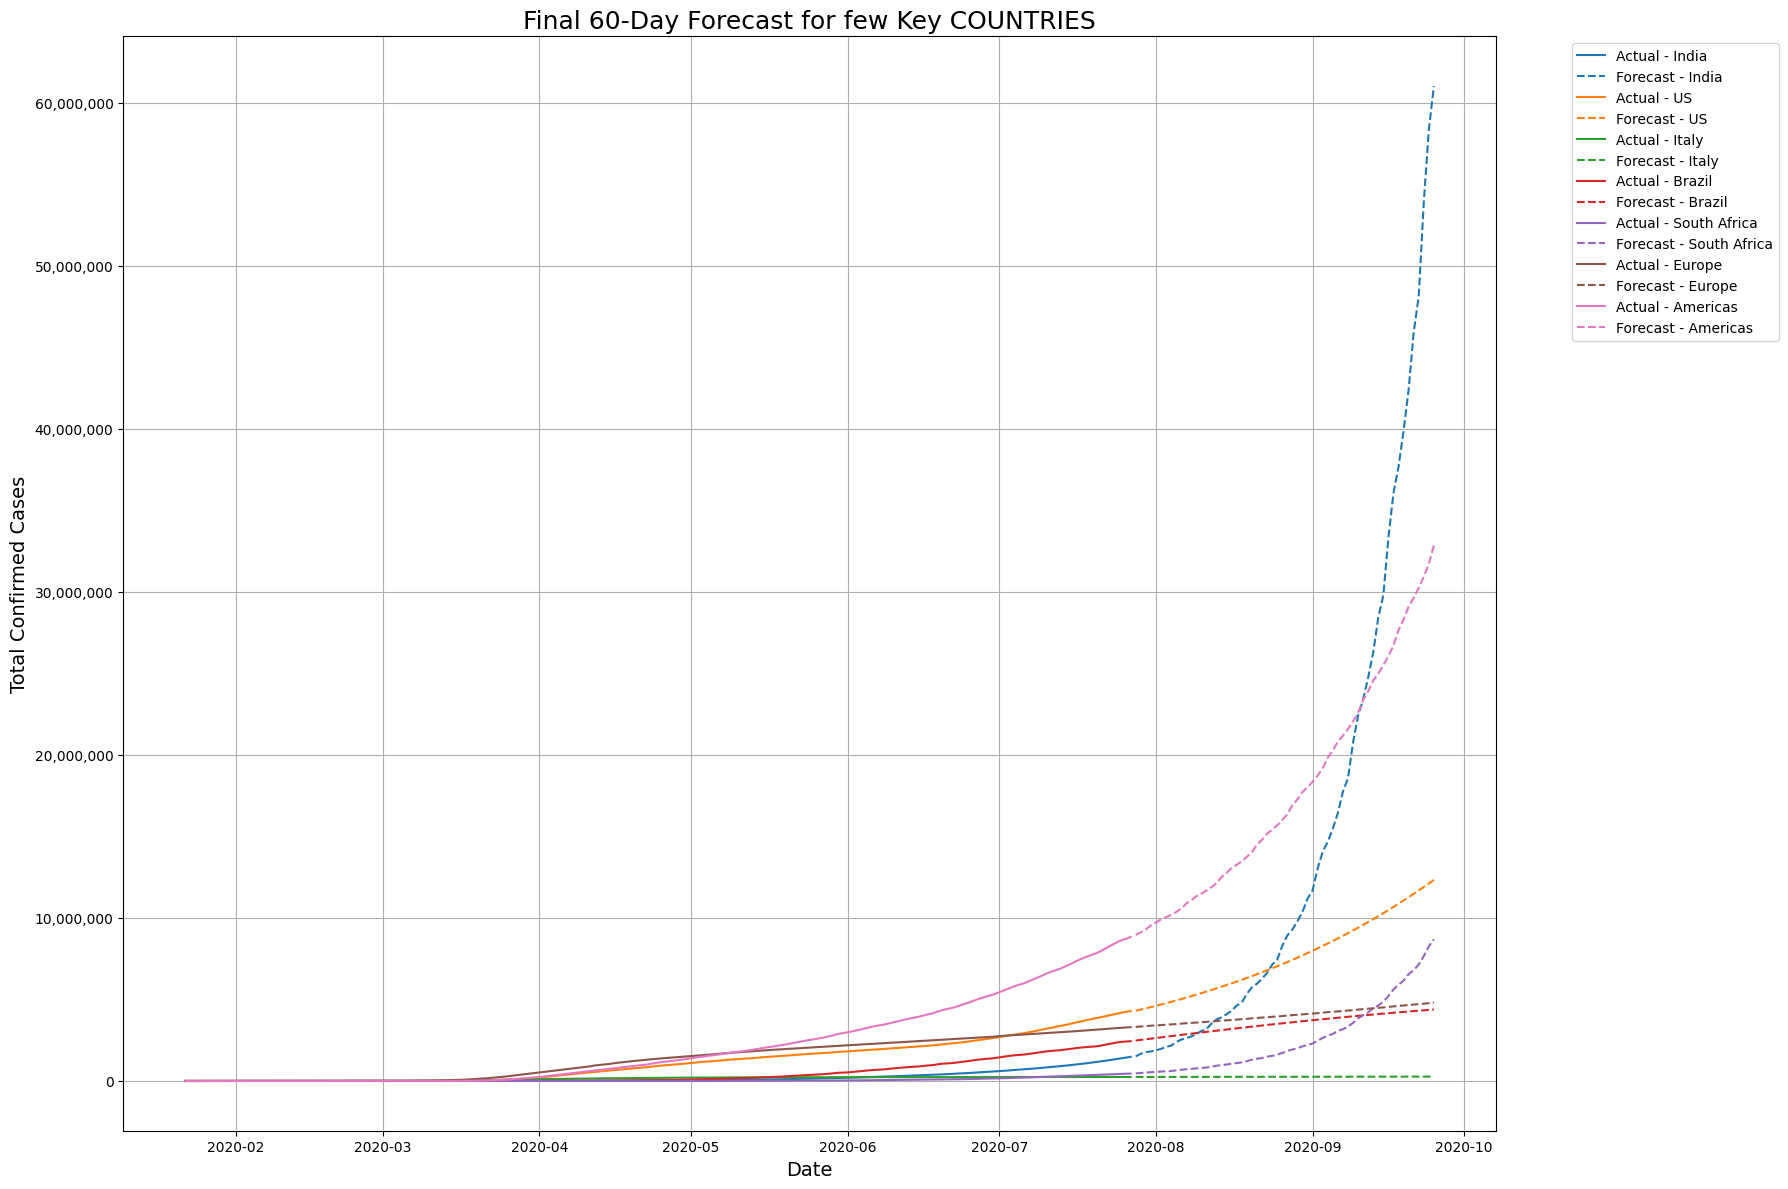

In [28]:
#CEll-20

# # Step- 10.1 > Forecasting 60 days forward By Best Optimised Moded For FEW important Countries

warnings.filterwarnings("ignore")

best_models_dict = best_models_df_country['Best Model (RMSE)'].to_dict()

plt.figure(figsize=(18, 12))
print("--- Final 60-Day Forecast Generation ... ---")

locations_to_plot = ['India', 'US', 'Italy', 'Brazil', 'South Africa', 'Europe', 'Americas']
colors = sns.color_palette('tab10', len(locations_to_plot))
location_color_map = dict(zip(locations_to_plot, colors))

for location in locations_to_plot:
    print(f"\n--- Location: {location}  Forecast... ---")

    best_model_name = best_models_dict.get(location, 'SARIMA')
    print(f"Best model : {best_model_name}")

    if location in df_clean['WHO Region'].unique():
        location_df = df_clean[df_clean['WHO Region'] == location].groupby('Date').sum().reset_index()
    else:
        location_df = df_clean[df_clean['Location'] == location].reset_index()

    try:
        if best_model_name == 'Regression':
            X_all = np.arange(len(location_df)).reshape(-1, 1)
            y_all = location_df['Confirmed'].values
            poly = PolynomialFeatures(degree=4)
            X_all_poly = poly.fit_transform(X_all)
            final_model = LinearRegression().fit(X_all_poly, y_all)

            future_days = np.arange(len(location_df), len(location_df) + 60).reshape(-1, 1)
            future_days_poly = poly.transform(future_days)
            forecast_values = final_model.predict(future_days_poly)

        else:
            log_series_all = np.log(location_df['Confirmed'] + 1)

            if best_model_name == 'ARIMA':
                final_model = ARIMA(log_series_all, order=(1, 1, 1)).fit()
            else:
                final_model = SARIMAX(log_series_all, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)


            forecast_log = final_model.forecast(steps=60)# Swith to inrcrease forecasting days
            forecast_values = np.exp(forecast_log)


        last_date = location_df['Date'].max()
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)


        plt.plot(location_df['Date'], location_df['Confirmed'], color=location_color_map[location], label=f'Actual - {location}')

        plt.plot(forecast_dates, forecast_values, color=location_color_map[location], linestyle='--', label=f'Forecast - {location}')

    except Exception as e:
        print(f"{location}  forecast Complete. Error: {e}")

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('Final 60-Day Forecast for few Key COUNTRIES', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Confirmed Cases', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


--- Generating Final 60-Day Forecast with Full Error Metrics ---

--- Processing Forecast for: India ---
Selected best model: SARIMA (Test Set RMSE: 158,198.0, MAPE: 10.61%)

--- Processing Forecast for: US ---
Selected best model: Regression (Test Set RMSE: 179,632.0, MAPE: 5.67%)

--- Processing Forecast for: Italy ---
Selected best model: SARIMA (Test Set RMSE: 2,744.0, MAPE: 0.97%)

--- Processing Forecast for: Brazil ---
Selected best model: ARIMA (Test Set RMSE: 21,907.0, MAPE: 0.91%)

--- Processing Forecast for: South Africa ---
Selected best model: SARIMA (Test Set RMSE: 110,135.0, MAPE: 27.05%)

--- Processing Forecast for: Europe ---
Selected best model: ARIMA (Test Set RMSE: 79,005.0, MAPE: 1.85%)

--- Processing Forecast for: Americas ---
Selected best model: ARIMA (Test Set RMSE: 719,700.0, MAPE: 7.42%)


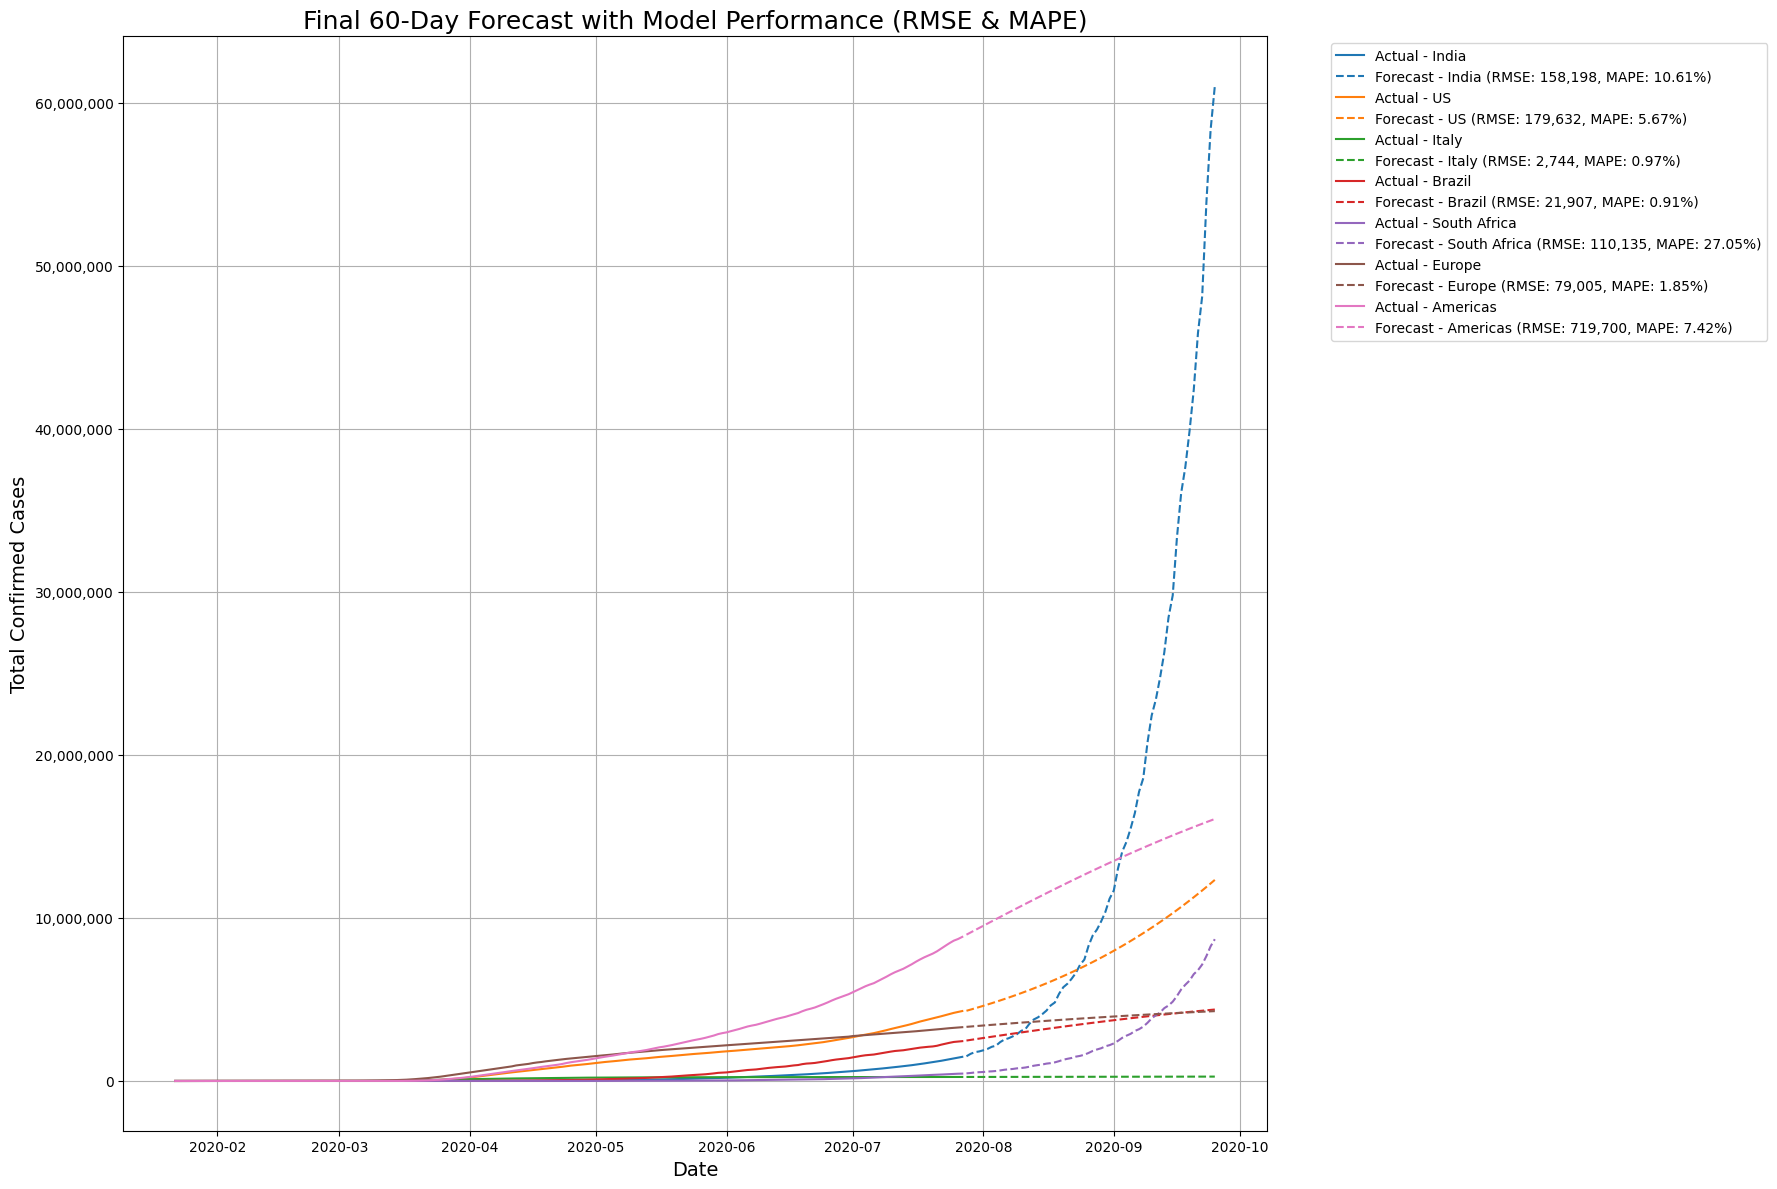

In [29]:
#Cell-21

# # Step- 10-2 > Error Measures of Forecasting 60 days forward By Best Optimised Moded For FEW important Countries

warnings.filterwarnings("ignore")

# --- 1. Prepare Best Model and Error Data ---
# This assumes you have run the comparison scripts and have the results DataFrames:
# 'best_models_df_country' and 'results_df_country' for countries
# 'best_models_df' and 'results_df' for WHO regions

# Create dictionaries to easily look up the best model and its errors
best_model_dict = {}
rmse_dict = {}
mape_dict = {}

# Populate dictionaries with country-level results
for location, row in results_df_country.iterrows():
    best_model_name = row[[col for col in row.index if 'RMSE' in col]].idxmin().replace('_RMSE', '')
    best_model_dict[location] = best_model_name
    rmse_dict[location] = row[f'{best_model_name}_RMSE']
    mape_dict[location] = row[f'{best_model_name}_MAPE']

# Populate dictionaries with WHO region-level results
for location, row in results_df.iterrows():
    best_model_name = row[[col for col in row.index if 'RMSE' in col]].idxmin().replace('_RMSE', '')
    best_model_dict[location] = best_model_name
    rmse_dict[location] = row[f'{best_model_name}_RMSE']
    mape_dict[location] = row[f'{best_model_name}_MAPE']


# --- 2. Setup for Final Plot ---
plt.figure(figsize=(18, 12))
print("--- Generating Final 60-Day Forecast with Full Error Metrics ---")

locations_to_plot = ['India', 'US', 'Italy', 'Brazil', 'South Africa', 'Europe', 'Americas']
colors = sns.color_palette('tab10', len(locations_to_plot))
location_color_map = dict(zip(locations_to_plot, colors))

# --- 3. Loop Through Each Location ---
for location in locations_to_plot:
    print(f"\n--- Processing Forecast for: {location} ---")

    # Look up the best model and its pre-calculated errors
    best_model_name = best_model_dict.get(location, 'SARIMA')
    model_rmse = rmse_dict.get(location, 'N/A')
    model_mape = mape_dict.get(location, 'N/A')

    print(f"Selected best model: {best_model_name} (Test Set RMSE: {model_rmse:,}, MAPE: {model_mape}%)")

    # Prepare data for the specific location
    if location in df_clean['WHO Region'].unique():
        location_df = df_clean[df_clean['WHO Region'] == location].groupby('Date').sum().reset_index()
    else:
        location_df = df_clean[df_clean['Location'] == location].reset_index()

    # --- 4. Retrain the Best Model on ALL Data ---
    try:
        if best_model_name == 'Regression':
            X_all = np.arange(len(location_df)).reshape(-1, 1)
            y_all = location_df['Confirmed'].values
            poly = PolynomialFeatures(degree=4)
            X_all_poly = poly.fit_transform(X_all)
            final_model = LinearRegression().fit(X_all_poly, y_all)

            future_days = np.arange(len(location_df), len(location_df) + 60).reshape(-1, 1)
            future_days_poly = poly.transform(future_days)
            forecast_values = final_model.predict(future_days_poly)

        else: # For ARIMA or SARIMA
            log_series_all = np.log(location_df['Confirmed'] + 1)

            if best_model_name == 'ARIMA':
                final_model = ARIMA(log_series_all, order=(1, 1, 1)).fit()
            else: # SARIMA
                final_model = SARIMAX(log_series_all, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)

            forecast_log = final_model.forecast(steps=60)
            forecast_values = np.exp(forecast_log)

        # --- 5. Visualize the Final Forecast with Both Errors ---
        last_date = location_df['Date'].max()
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

        plt.plot(location_df['Date'], location_df['Confirmed'], color=location_color_map[location], label=f'Actual - {location}')
        # Include both RMSE and MAPE in the forecast label
        plt.plot(forecast_dates, forecast_values, color=location_color_map[location], linestyle='--', label=f'Forecast - {location} (RMSE: {int(model_rmse):,}, MAPE: {model_mape}%)')

    except Exception as e:
        print(f"Could not generate forecast for {location}. Error: {e}")

# --- 6. Final Plot Formatting ---
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('Final 60-Day Forecast with Model Performance (RMSE & MAPE)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Confirmed Cases', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
#Cell-22

# # Step- 10-3 > Error Measures of Forecasting 60 days forward By Best Optimised Moded For FEW important Countries

# This assumes 'results_df_country' is the DataFrame from our country-level comparison.
# If not, you would need to run the comparison script first.

# --- 1. Define the key countries for the report ---
key_countries = ['India', 'US', 'Italy', 'Brazil', 'South Africa',]

# Filter the main results table to only include these countries
results_key_countries = results_df_country[results_df_country.index.isin(key_countries)]


# --- 2. Initialize a list to store the final summary results ---
summary_list = []

# --- 3. Loop through the filtered results for each country ---
for location, row in results_key_countries.iterrows():

    # --- A. Find the Best Model based on the lowest RMSE ---
    # Get all the RMSE columns
    rmse_cols = [col for col in results_key_countries.columns if 'RMSE' in col]
    # Find the column name with the minimum RMSE value for the current row
    best_model_col = row[rmse_cols].idxmin()
    # Extract the model name (e.g., 'SARIMA' from 'SARIMA_RMSE')
    best_model_name = best_model_col.replace('_RMSE', '')

    # --- B. Get the corresponding metrics for the best model ---
    best_rmse = row[f'{best_model_name}_RMSE']
    best_mae = row[f'{best_model_name}_MAE']
    best_mape = row[f'{best_model_name}_MAPE']

    # --- C. Add the summary to our list ---
    summary_list.append({
        'Country': location,
        'Best Model': best_model_name,
        'RMSE': f"{int(best_rmse):,}", # Format with commas
        'MAE': f"{int(best_mae):,}",  # Format with commas
        'MAPE (%)': best_mape
    })

# --- 4. Create the Final Report DataFrame ---
final_report_df_country = pd.DataFrame(summary_list).set_index('Country')

# --- 5. Display the Final Report Table ---
print("--- Final Report: Best Model Performance by Key Country ---")
print(final_report_df_country)


--- Final Report: Best Model Performance by Key Country ---
              Best Model     RMSE      MAE  MAPE (%)
Country                                             
Brazil             ARIMA   21,907   16,048      0.91
India             SARIMA  158,198  112,834     10.61
Italy             SARIMA    2,744    2,359      0.97
South Africa      SARIMA  110,135   84,646     27.05
US            Regression  179,632  163,557      5.67


#For WHO Region Level

--- Generating Final 60-Day Forecasts for WHO Regions ---

--- Processing Forecast for: Eastern Mediterranean ---
Selected best model: ARIMA (Test Set RMSE: 90,997.0, MAPE: 5.26%)

--- Processing Forecast for: Europe ---
Selected best model: ARIMA (Test Set RMSE: 79,005.0, MAPE: 1.85%)

--- Processing Forecast for: Africa ---
Selected best model: SARIMA (Test Set RMSE: 127,235.0, MAPE: 17.68%)

--- Processing Forecast for: Americas ---
Selected best model: ARIMA (Test Set RMSE: 719,700.0, MAPE: 7.42%)

--- Processing Forecast for: Western Pacific ---
Selected best model: SARIMA (Test Set RMSE: 20,253.0, MAPE: 5.59%)

--- Processing Forecast for: South-East Asia ---
Selected best model: ARIMA (Test Set RMSE: 31,485.0, MAPE: 1.13%)


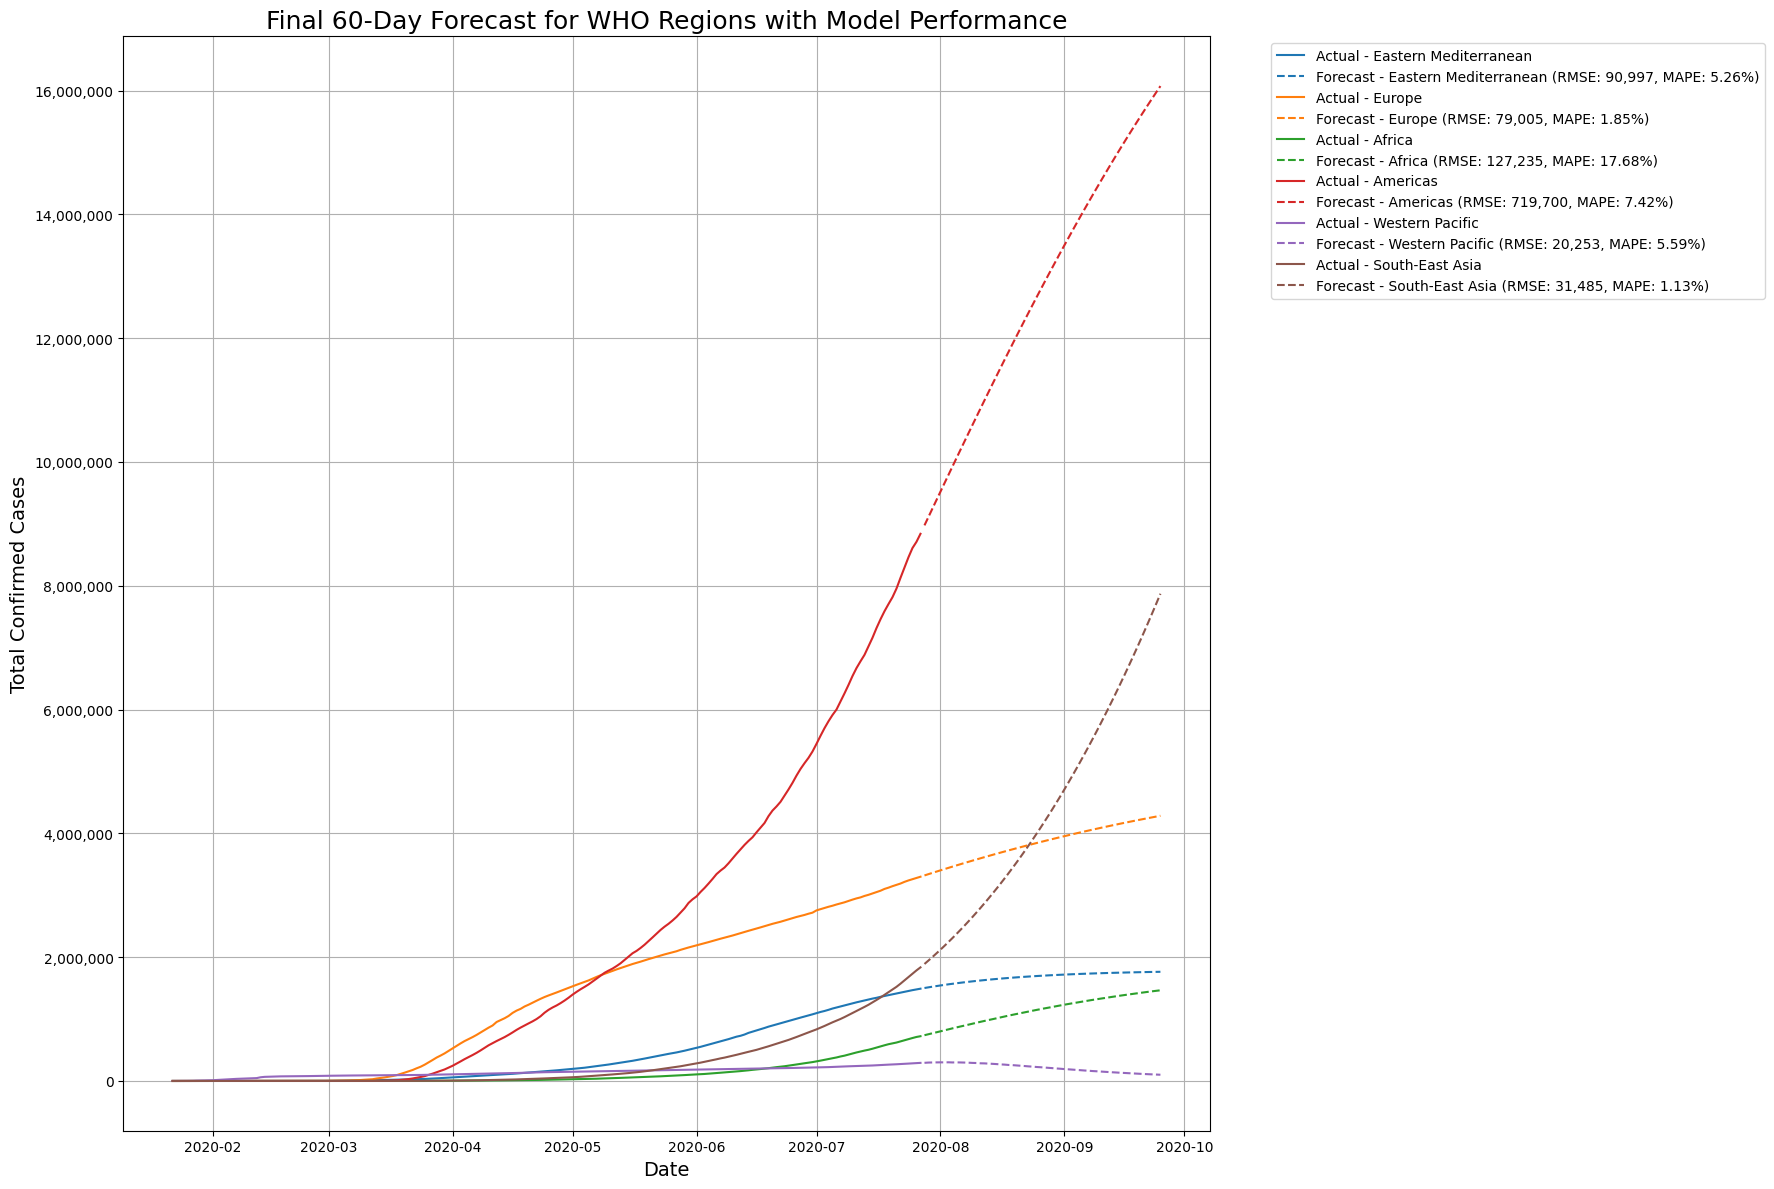

In [33]:
#Cell-23

# Step- 11-1 > Error Measures + Forecasting 60 days forward By Best Optimised Moded For WHO Regions

warnings.filterwarnings("ignore")

# --- 1. Prepare Best Model and Error Data ---
# This assumes you have the results DataFrames from your previous comparisons:
# 'results_df' for WHO regions.

# Create dictionaries to easily look up the best model and its errors
best_model_dict = {}
rmse_dict = {}
mape_dict = {}

# Populate dictionaries with WHO region-level results
for location, row in results_df.iterrows():
    # Find the best model based on the lowest RMSE for the current region
    rmse_cols = [col for col in row.index if 'RMSE' in col]
    best_model_name = row[rmse_cols].idxmin().replace('_RMSE', '')

    # Store the best model name and its corresponding metrics
    best_model_dict[location] = best_model_name
    rmse_dict[location] = row[f'{best_model_name}_RMSE']
    mape_dict[location] = row[f'{best_model_name}_MAPE']


# --- 2. Setup for Final Plot ---
plt.figure(figsize=(18, 12))
print("--- Generating Final 60-Day Forecasts for WHO Regions ---")

# We will plot all WHO regions
locations_to_plot = df_clean['WHO Region'].unique()
colors = sns.color_palette('tab10', len(locations_to_plot))
location_color_map = dict(zip(locations_to_plot, colors))

# --- 3. Loop Through Each WHO Region to Generate Forecast ---
for location in locations_to_plot:
    print(f"\n--- Processing Forecast for: {location} ---")

    # Look up the best model and its pre-calculated errors
    best_model_name = best_model_dict.get(location, 'SARIMA') # Default to SARIMA if not found
    model_rmse = rmse_dict.get(location, 0)
    model_mape = mape_dict.get(location, 0)

    print(f"Selected best model: {best_model_name} (Test Set RMSE: {model_rmse:,}, MAPE: {model_mape}%)")

    # Prepare data for the specific location
    location_df = df_clean[df_clean['WHO Region'] == location].groupby('Date').sum().reset_index()

    # --- 4. Retrain the Best Model on ALL Available Data ---
    try:
        if best_model_name == 'Regression':
            X_all = np.arange(len(location_df)).reshape(-1, 1)
            y_all = location_df['Confirmed'].values
            poly = PolynomialFeatures(degree=4)
            X_all_poly = poly.fit_transform(X_all)
            final_model = LinearRegression().fit(X_all_poly, y_all)

            # Create future time steps for forecasting
            future_days = np.arange(len(location_df), len(location_df) + 60).reshape(-1, 1)
            future_days_poly = poly.transform(future_days)
            forecast_values = final_model.predict(future_days_poly)

        else: # For ARIMA or SARIMA models
            log_series_all = np.log(location_df['Confirmed'] + 1)

            if best_model_name == 'ARIMA':
                final_model = ARIMA(log_series_all, order=(1, 1, 1)).fit()
            else: # SARIMA
                final_model = SARIMAX(log_series_all, order=(1, 1, 1), seasonal_order=(1, 0, 2, 7)).fit(disp=False)

            # Forecast the next 60 steps
            forecast_log = final_model.forecast(steps=60)
            forecast_values = np.exp(forecast_log)

        # --- 5. Visualize the Final Forecast ---
        last_date = location_df['Date'].max()
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

        # Plot the historical data
        plt.plot(location_df['Date'], location_df['Confirmed'], color=location_color_map[location], label=f'Actual - {location}')
        # Plot the forecast, including error metrics in the label
        plt.plot(forecast_dates, forecast_values, color=location_color_map[location], linestyle='--', label=f'Forecast - {location} (RMSE: {int(model_rmse):,}, MAPE: {model_mape}%)')

    except Exception as e:
        print(f"Could not generate forecast for {location}. Error: {e}")

# --- 6. Final Plot Formatting ---
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('Final 60-Day Forecast for WHO Regions with Model Performance', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Confirmed Cases', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
#Cell-24

# # Step- 11-2 > Error Measures of Forecasting 60 days forward By Best Optimised Moded For FEW important Countries

# --- 1. Initialize a list to store the final summary results ---
summary_list = []

# --- 2. Loop through the results DataFrame for each region ---
for region, row in results_df.iterrows():

    # --- A. Find the Best Model based on the lowest RMSE ---
    # Get all the RMSE columns
    rmse_cols = [col for col in results_df.columns if 'RMSE' in col]
    # Find the column name with the minimum RMSE value for the current row
    best_model_col = row[rmse_cols].idxmin()
    # Extract the model name (e.g., 'SARIMA' from 'SARIMA_RMSE')
    best_model_name = best_model_col.replace('_RMSE', '')

    # --- B. Get the corresponding metrics for the best model ---
    best_rmse = row[f'{best_model_name}_RMSE']
    best_mae = row[f'{best_model_name}_MAE']
    best_mape = row[f'{best_model_name}_MAPE']

    # --- C. Add the summary to our list ---
    summary_list.append({
        'WHO Region': region,
        'Best Model': best_model_name,
        'RMSE': f"{int(best_rmse):,}", # Format with commas
        'MAE': f"{int(best_mae):,}",  # Format with commas
        'MAPE (%)': best_mape
    })

# --- 3. Create the Final Report DataFrame ---
final_report_df = pd.DataFrame(summary_list).set_index('WHO Region')

# --- 4. Display the Final Report Table ---
print("--- Final Report: Best Model Performance by WHO Region ---")
print(final_report_df)


--- Final Report: Best Model Performance by WHO Region ---
                      Best Model     RMSE      MAE  MAPE (%)
WHO Region                                                  
Eastern Mediterranean      ARIMA   90,997   70,786      5.26
Europe                     ARIMA   79,005   57,349      1.85
Africa                    SARIMA  127,235   96,017     17.68
Americas                   ARIMA  719,700  549,232      7.42
Western Pacific           SARIMA   20,253   14,682      5.59
South-East Asia            ARIMA   31,485   17,181      1.13


#**8. Saving the Forecast Result**

--- Generating Final 60-Day Forecasts for Key Countries ---

--- Processing Forecast for: India ---
Selected best model: SARIMA (Test Set RMSE: 158,198.0, MAPE: 10.61%)

--- Processing Forecast for: US ---
Selected best model: Regression (Test Set RMSE: 179,632.0, MAPE: 5.67%)

--- Processing Forecast for: Italy ---
Selected best model: SARIMA (Test Set RMSE: 2,744.0, MAPE: 0.97%)

--- Processing Forecast for: Brazil ---
Selected best model: ARIMA (Test Set RMSE: 21,907.0, MAPE: 0.91%)

--- Processing Forecast for: South Africa ---
Selected best model: SARIMA (Test Set RMSE: 110,135.0, MAPE: 27.05%)


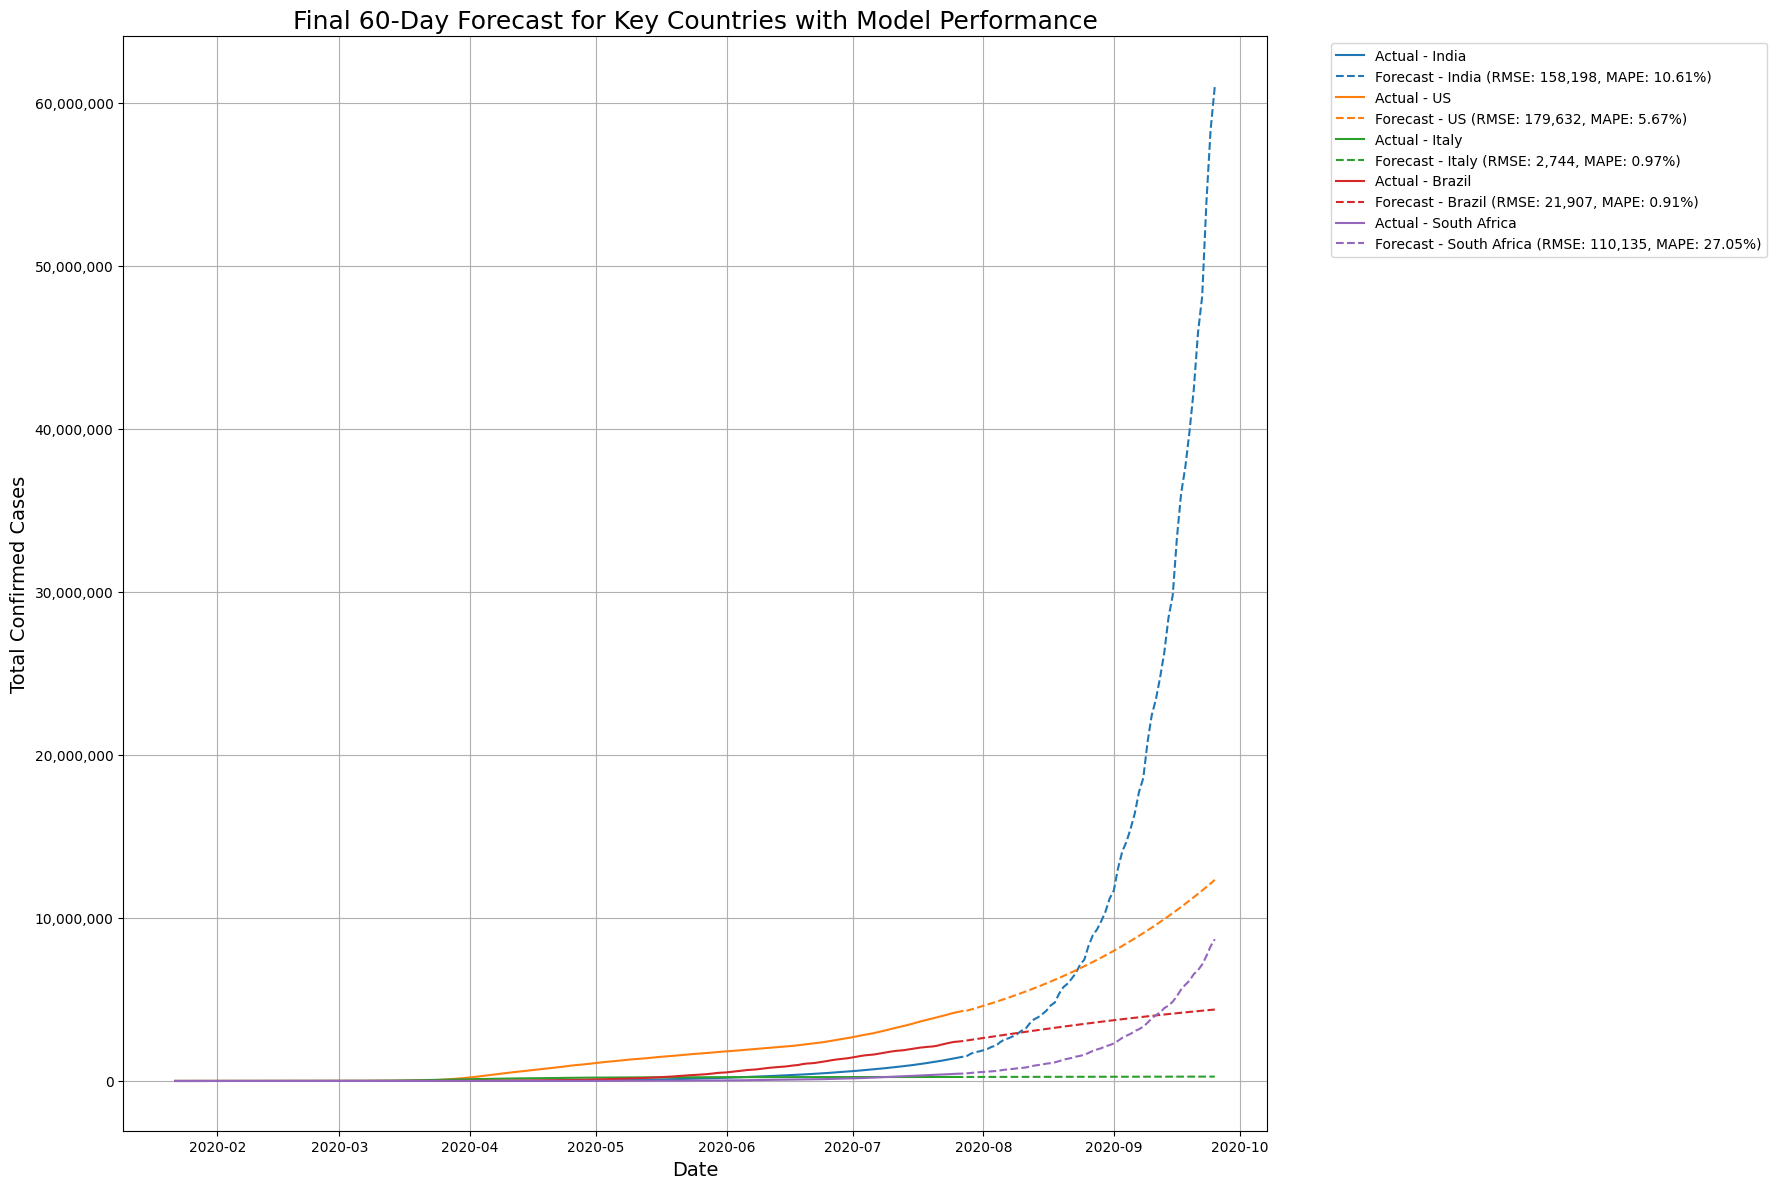


--- Saving country-level forecast results to CSV files ---
Successfully saved 'country_forecast_results_only.csv'
Successfully saved 'country_model_ready_with_forecasts.csv'


In [37]:
#Cell-25

# # Step- 12 > Generating Forecast Result as Output CSV

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

# --- 1. Prepare Best Model and Error Data ---
# This assumes you have the results DataFrame 'results_df_country' from the country-level comparison.

# Create dictionaries to easily look up the best model and its errors
best_model_dict = {}
rmse_dict = {}
mape_dict = {}

# Populate dictionaries with country-level results
for location, row in results_df_country.iterrows():
    rmse_cols = [col for col in row.index if 'RMSE' in col]
    best_model_name = row[rmse_cols].idxmin().replace('_RMSE', '')

    best_model_dict[location] = best_model_name
    rmse_dict[location] = row[f'{best_model_name}_RMSE']
    mape_dict[location] = row[f'{best_model_name}_MAPE']


# --- 2. Setup for Final Plot and Data Collection ---
plt.figure(figsize=(18, 12))
print("--- Generating Final 60-Day Forecasts for Key Countries ---")
all_forecasts_list = [] # To store forecast data for CSV export
combined_data_list = [] # To store historical + forecast data for CSV export

# We will plot a few key countries
locations_to_plot = ['India', 'US', 'Italy', 'Brazil', 'South Africa']
colors = sns.color_palette('tab10', len(locations_to_plot))
location_color_map = dict(zip(locations_to_plot, colors))

# --- 3. Loop Through Each Country to Generate Forecast ---
for location in locations_to_plot:
    print(f"\n--- Processing Forecast for: {location} ---")

    best_model_name = best_model_dict.get(location, 'SARIMA')
    model_rmse = rmse_dict.get(location, 0)
    model_mape = mape_dict.get(location, 0)

    print(f"Selected best model: {best_model_name} (Test Set RMSE: {model_rmse:,}, MAPE: {model_mape}%)")

    # Prepare data for the specific location
    location_df = df_clean[df_clean['Location'] == location].reset_index()
    combined_data_list.append(location_df[['Date', 'Confirmed']].assign(Location=location))

    # --- 4. Retrain the Best Model on ALL Available Data ---
    try:
        if best_model_name == 'Regression':
            X_all = np.arange(len(location_df)).reshape(-1, 1)
            y_all = location_df['Confirmed'].values
            poly = PolynomialFeatures(degree=4)
            X_all_poly = poly.fit_transform(X_all)
            final_model = LinearRegression().fit(X_all_poly, y_all)

            future_days = np.arange(len(location_df), len(location_df) + 60).reshape(-1, 1)
            future_days_poly = poly.transform(future_days)
            forecast_values = final_model.predict(future_days_poly)

        else: # For ARIMA or SARIMA models
            log_series_all = np.log(location_df['Confirmed'] + 1)

            if best_model_name == 'ARIMA':
                final_model = ARIMA(log_series_all, order=(1, 1, 1)).fit()
            else: # SARIMA
                final_model = SARIMAX(log_series_all, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)

            forecast_log = final_model.forecast(steps=60)
            forecast_values = np.exp(forecast_log)

        # --- 5. Visualize and Store the Final Forecast ---
        last_date = location_df['Date'].max()
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

        plt.plot(location_df['Date'], location_df['Confirmed'], color=location_color_map[location], label=f'Actual - {location}')
        plt.plot(forecast_dates, forecast_values, color=location_color_map[location], linestyle='--', label=f'Forecast - {location} (RMSE: {int(model_rmse):,}, MAPE: {model_mape}%)')

        # Store forecast for CSV export
        forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Confirmed': forecast_values, 'Location': location})
        all_forecasts_list.append(forecast_df)
        combined_data_list.append(forecast_df.rename(columns={'Forecasted_Confirmed': 'Confirmed'}))

    except Exception as e:
        print(f"Could not generate forecast for {location}. Error: {e}")

# --- 6. Final Plot Formatting ---
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, p: format(int(val), ',')))
plt.title('Final 60-Day Forecast for Key Countries with Model Performance', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Confirmed Cases', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. Create and Save CSV Files ---
print("\n--- Saving country-level forecast results to CSV files ---")

# Create the first CSV: Forecasts only
forecasts_only_df_country = pd.concat(all_forecasts_list, ignore_index=True)
forecasts_only_df_country.to_csv('country_forecast_results_only.csv', index=False)
print("Successfully saved 'country_forecast_results_only.csv'")

# Create the second CSV: Model-ready data appended with forecasts
model_ready_with_forecasts_df_country = pd.concat(combined_data_list, ignore_index=True)
model_ready_with_forecasts_df_country.sort_values(by=['Location', 'Date'], inplace=True)
model_ready_with_forecasts_df_country.to_csv('country_model_ready_with_forecasts.csv', index=False)
print("Successfully saved 'country_model_ready_with_forecasts.csv'")
